In [77]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats as stats
import scipy.spatial as spatial
from sklearn.metrics import normalized_mutual_info_score

from spring_embedding_models import SequentialHierarchyCommunitySimple, SequentialHierarchyCommunitySimpleJAX, SequentialHierarchyCommunityMulti, SequentialHierarchyCommunityMultiJAX
import utils
from springrank import SpringRank

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def load_labeled_network_and_get_largest_wcc(edge_file, node_file):
    # Step 1: Read node labels
    with open(node_file, 'r') as f:
        node_labels = set(line.strip().split(',')[0] for line in f if line.strip())

    # Step 2: Read edge list with labels directly
    G = nx.read_edgelist(edge_file, create_using=nx.DiGraph(), nodetype=str, delimiter=',')
    G = G.reverse(copy=True)

    # Step 3: Filter to only valid nodes from node list
    G = G.subgraph([n for n in G.nodes if n in node_labels]).copy()

    # Step 4: Get largest weakly connected component
    components = list(nx.weakly_connected_components(G))
    largest_wcc = max(components, key=len)
    G_wcc = G.subgraph(largest_wcc).copy()

    return G_wcc

In [4]:
G_wcc = load_labeled_network_and_get_largest_wcc('data/1998_fall_edge_list.csv', 'data/1998_fall_node_list.csv')
node_list = list(G_wcc.nodes)
A_wcc = nx.to_numpy_array(G_wcc, nodelist=node_list)

  0%|          | 0/300 [00:00<?, ?it/s]

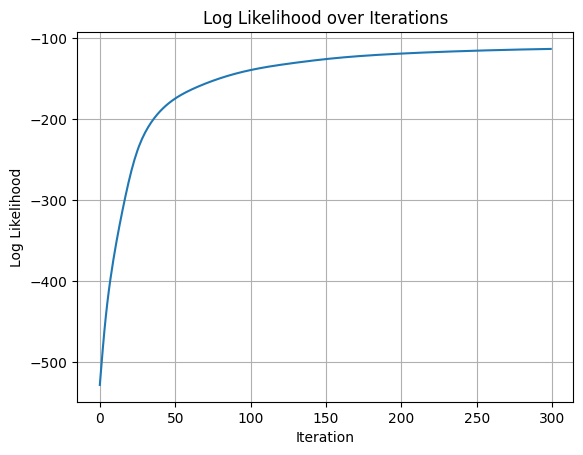

In [16]:
simple_model = SequentialHierarchyCommunitySimple(adj_matrix=A_wcc, embedding_dim=4, alpha=5, beta=1)
_ = simple_model.fit()

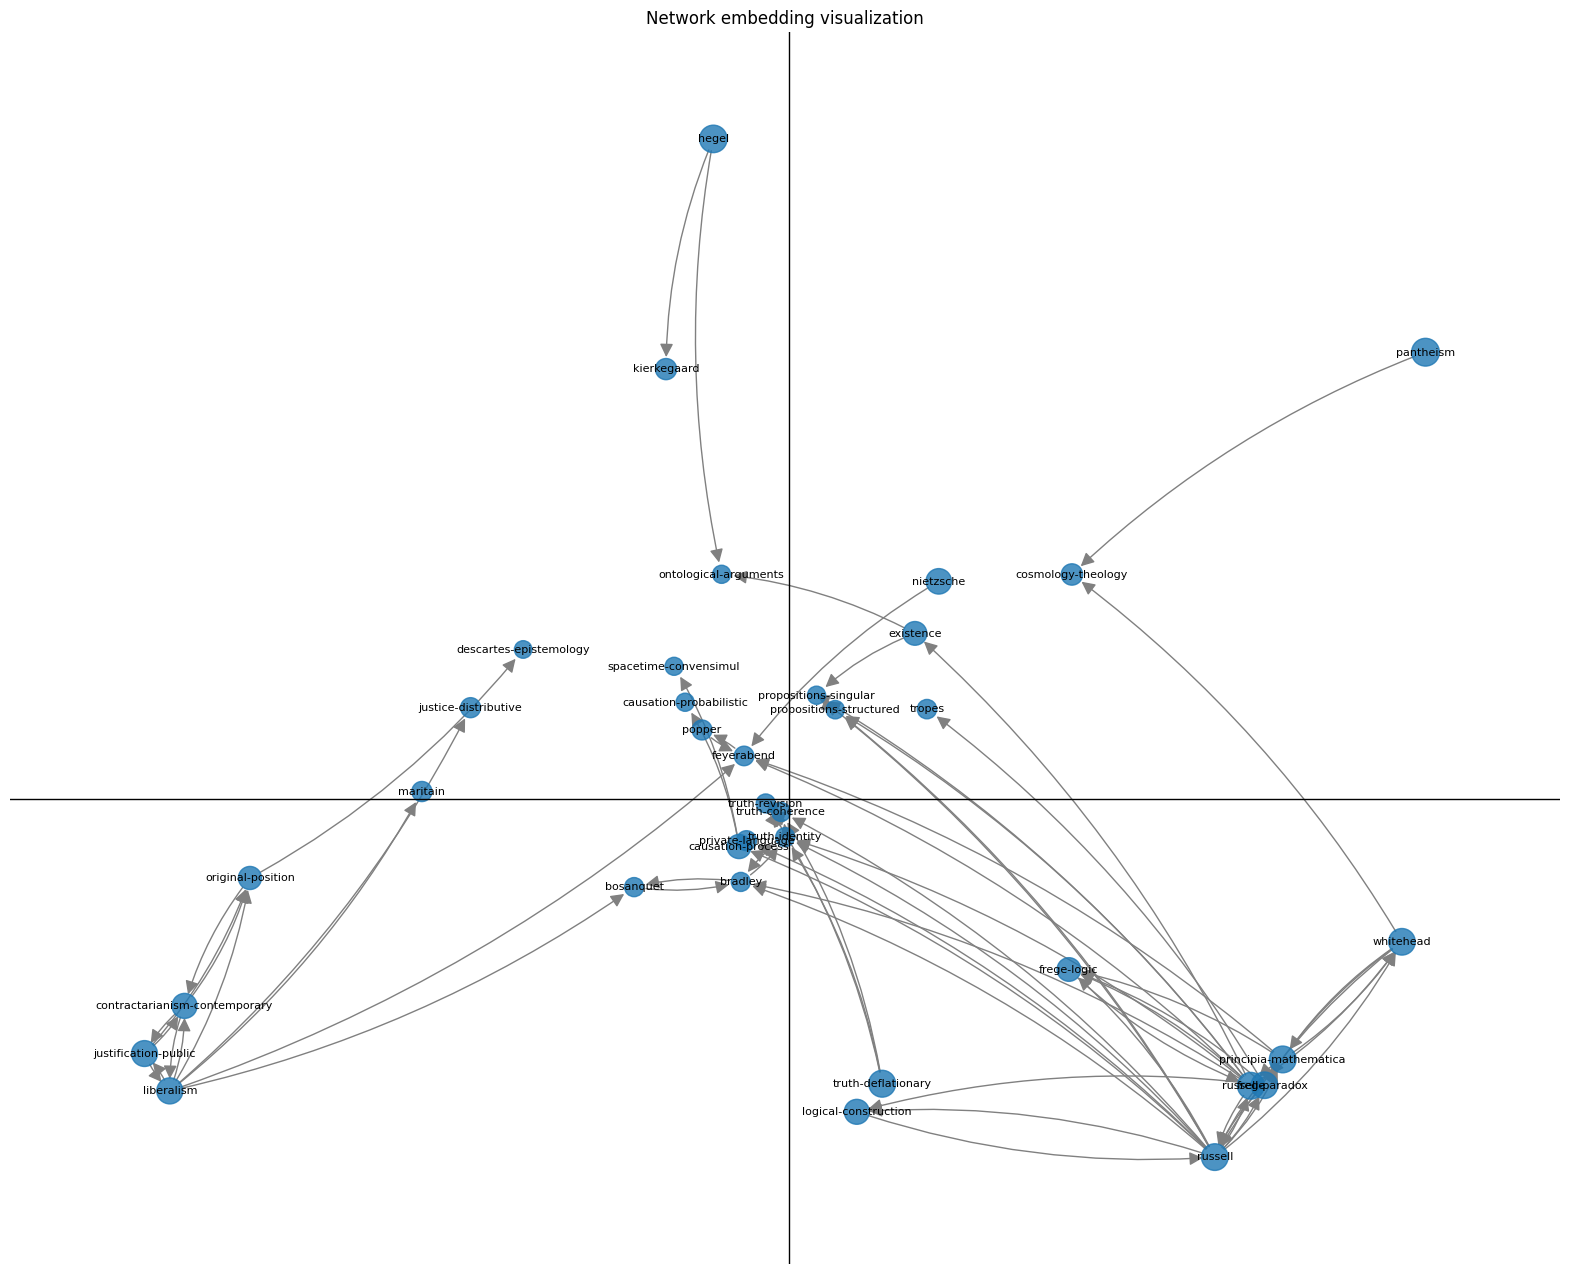

In [17]:
simple_model.visualize(node_labels=node_list)

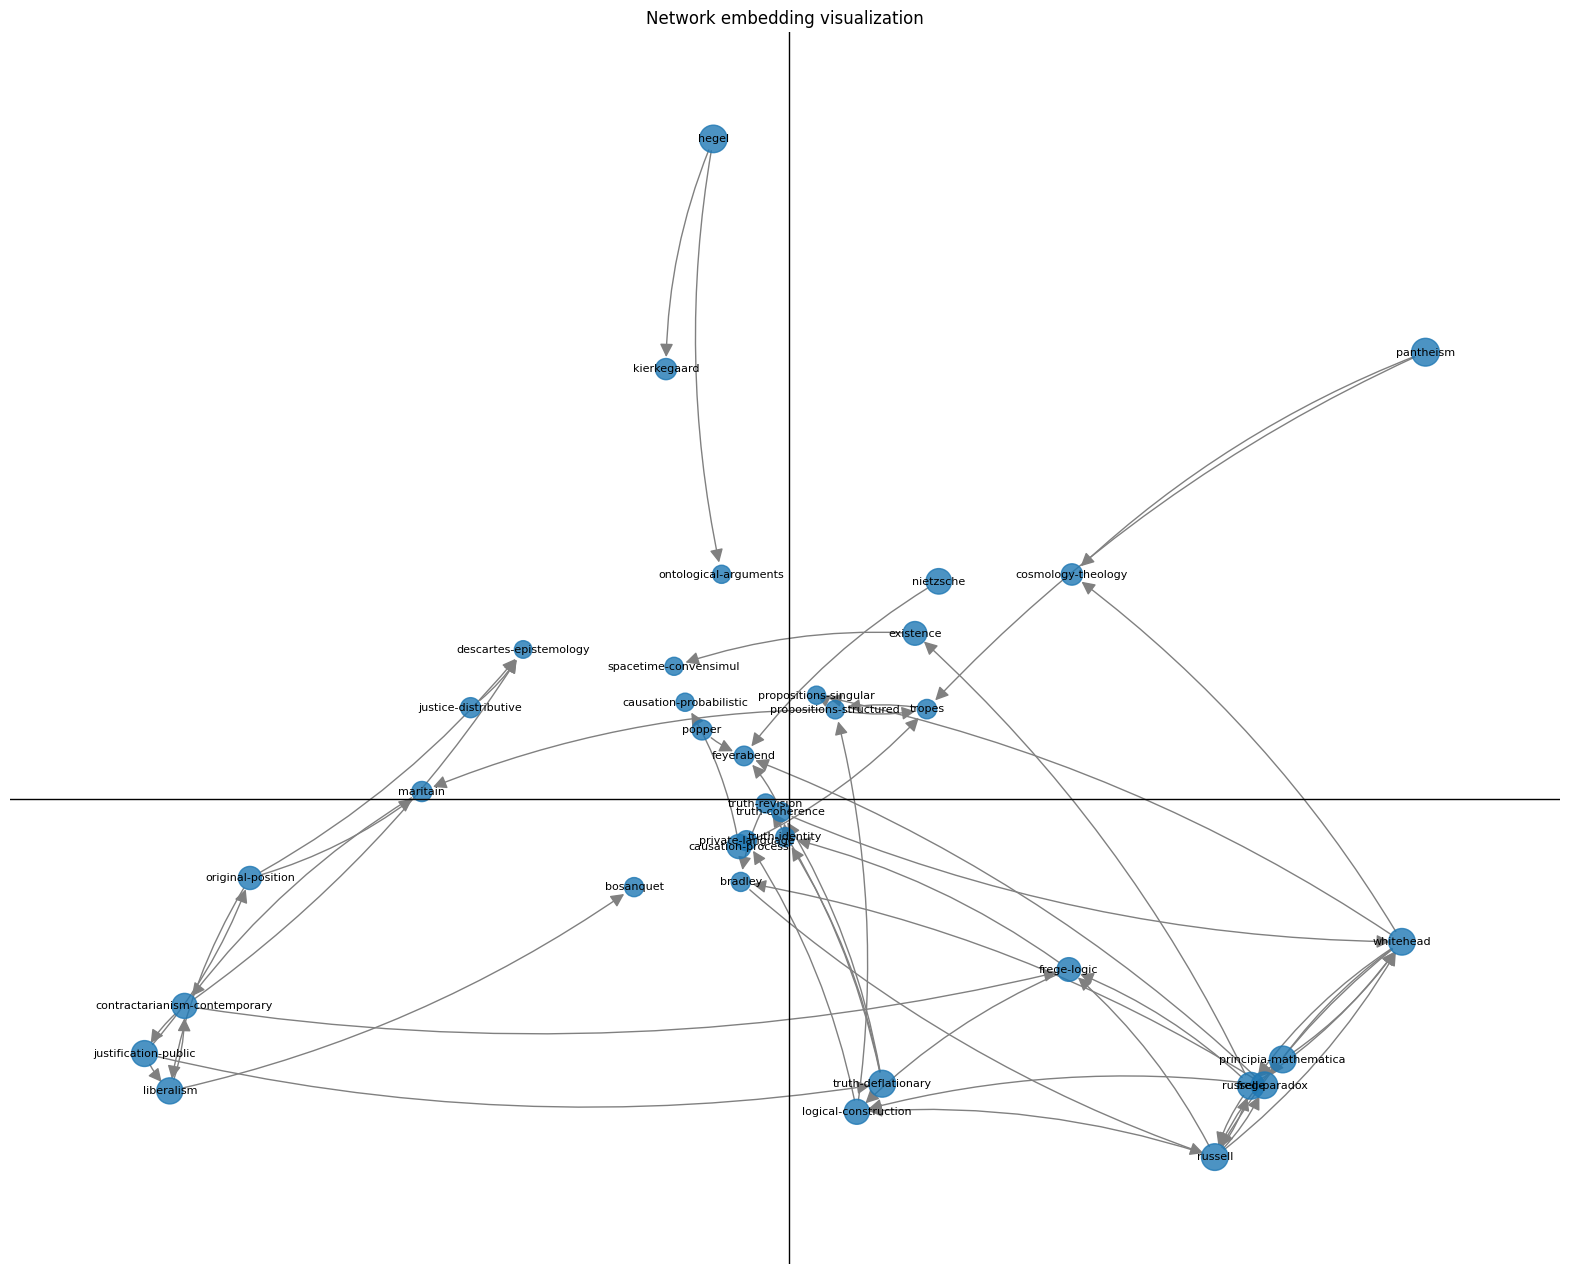

In [18]:
A_gen_simple = simple_model.generate()
simple_model.visualize(
    node_labels=node_list,
    adj_matrix=A_gen_simple,
)

## Test the simple model on a ring network

In [67]:
A_ring = np.zeros([20, 20])
for i in range(len(A_ring)):
    A_ring[i, (i+1) % A_ring.shape[0]] = 1

  0%|          | 0/300 [00:00<?, ?it/s]

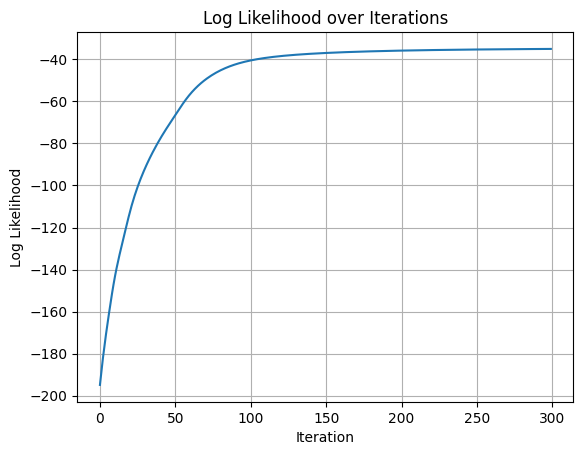

In [74]:
simple_model_ring = SequentialHierarchyCommunitySimple(adj_matrix=A_ring, embedding_dim=4, alpha=8, beta=1)
_ = simple_model_ring.fit()

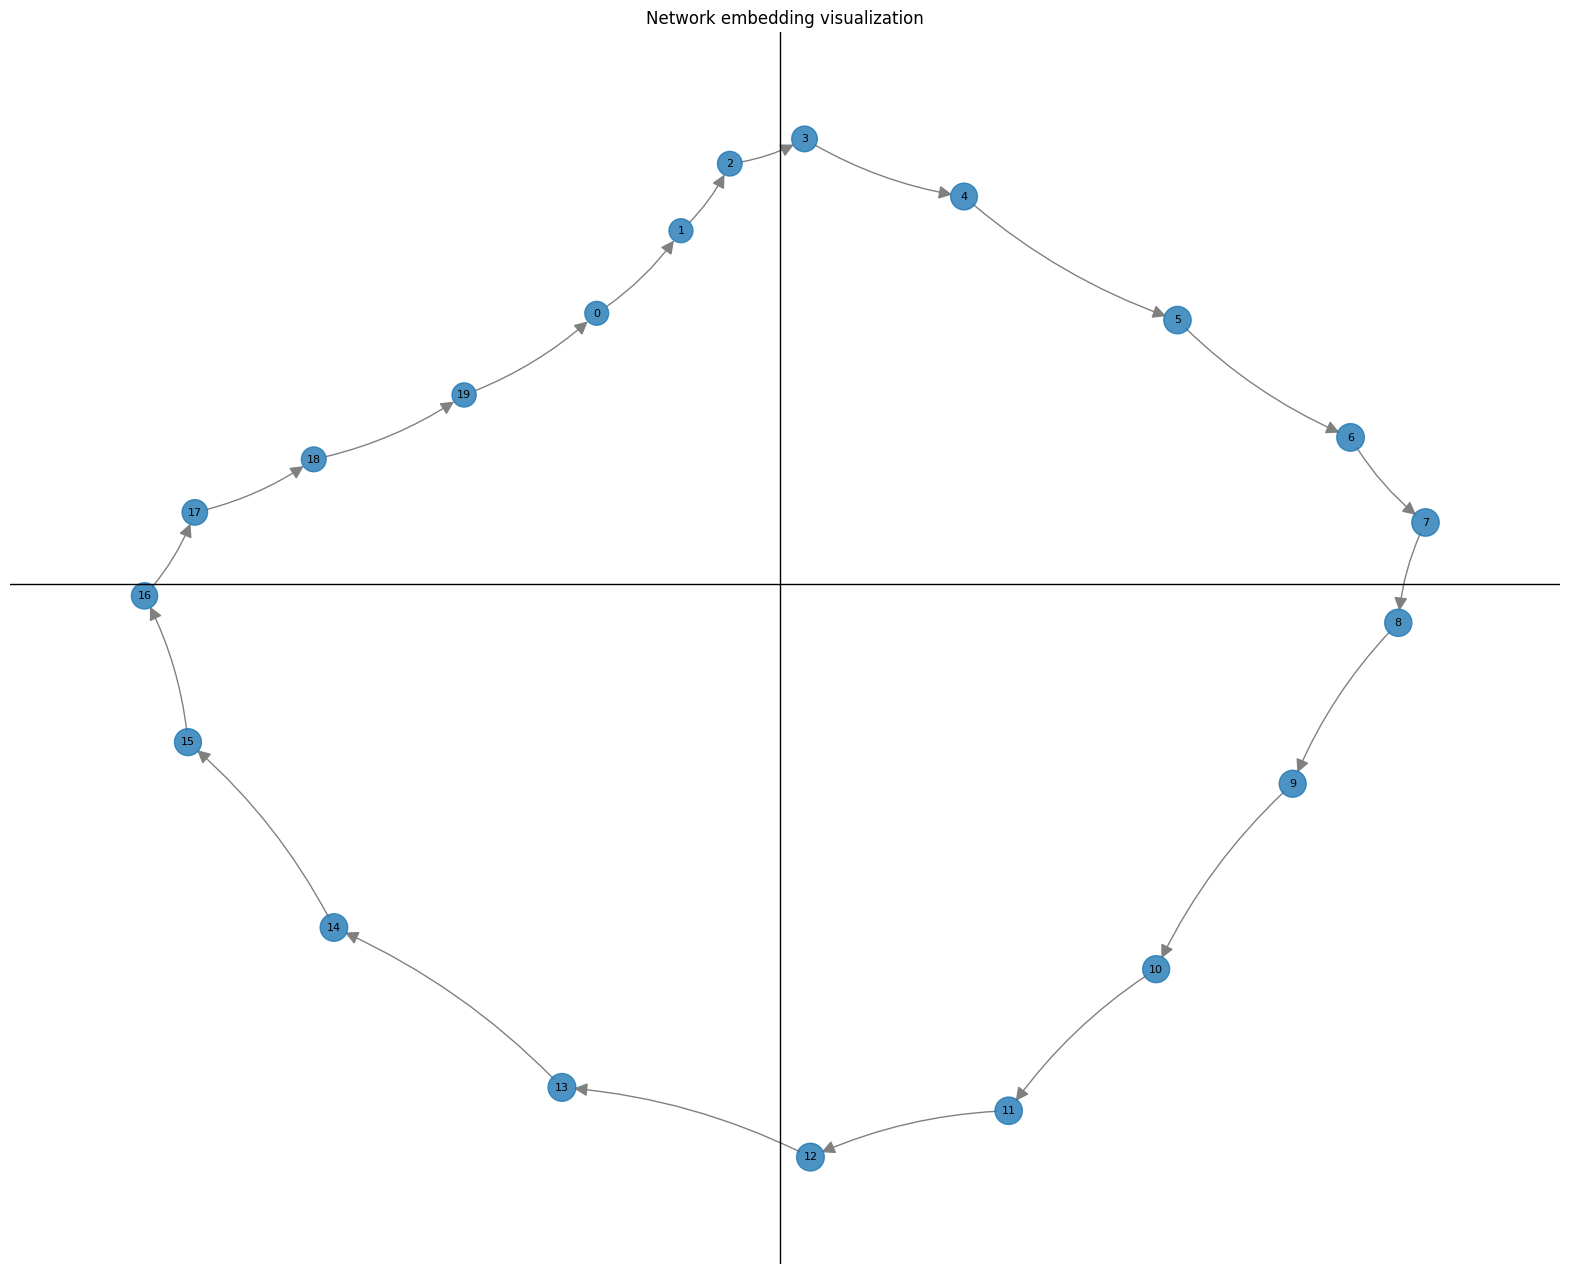

In [75]:
simple_model_ring.visualize()

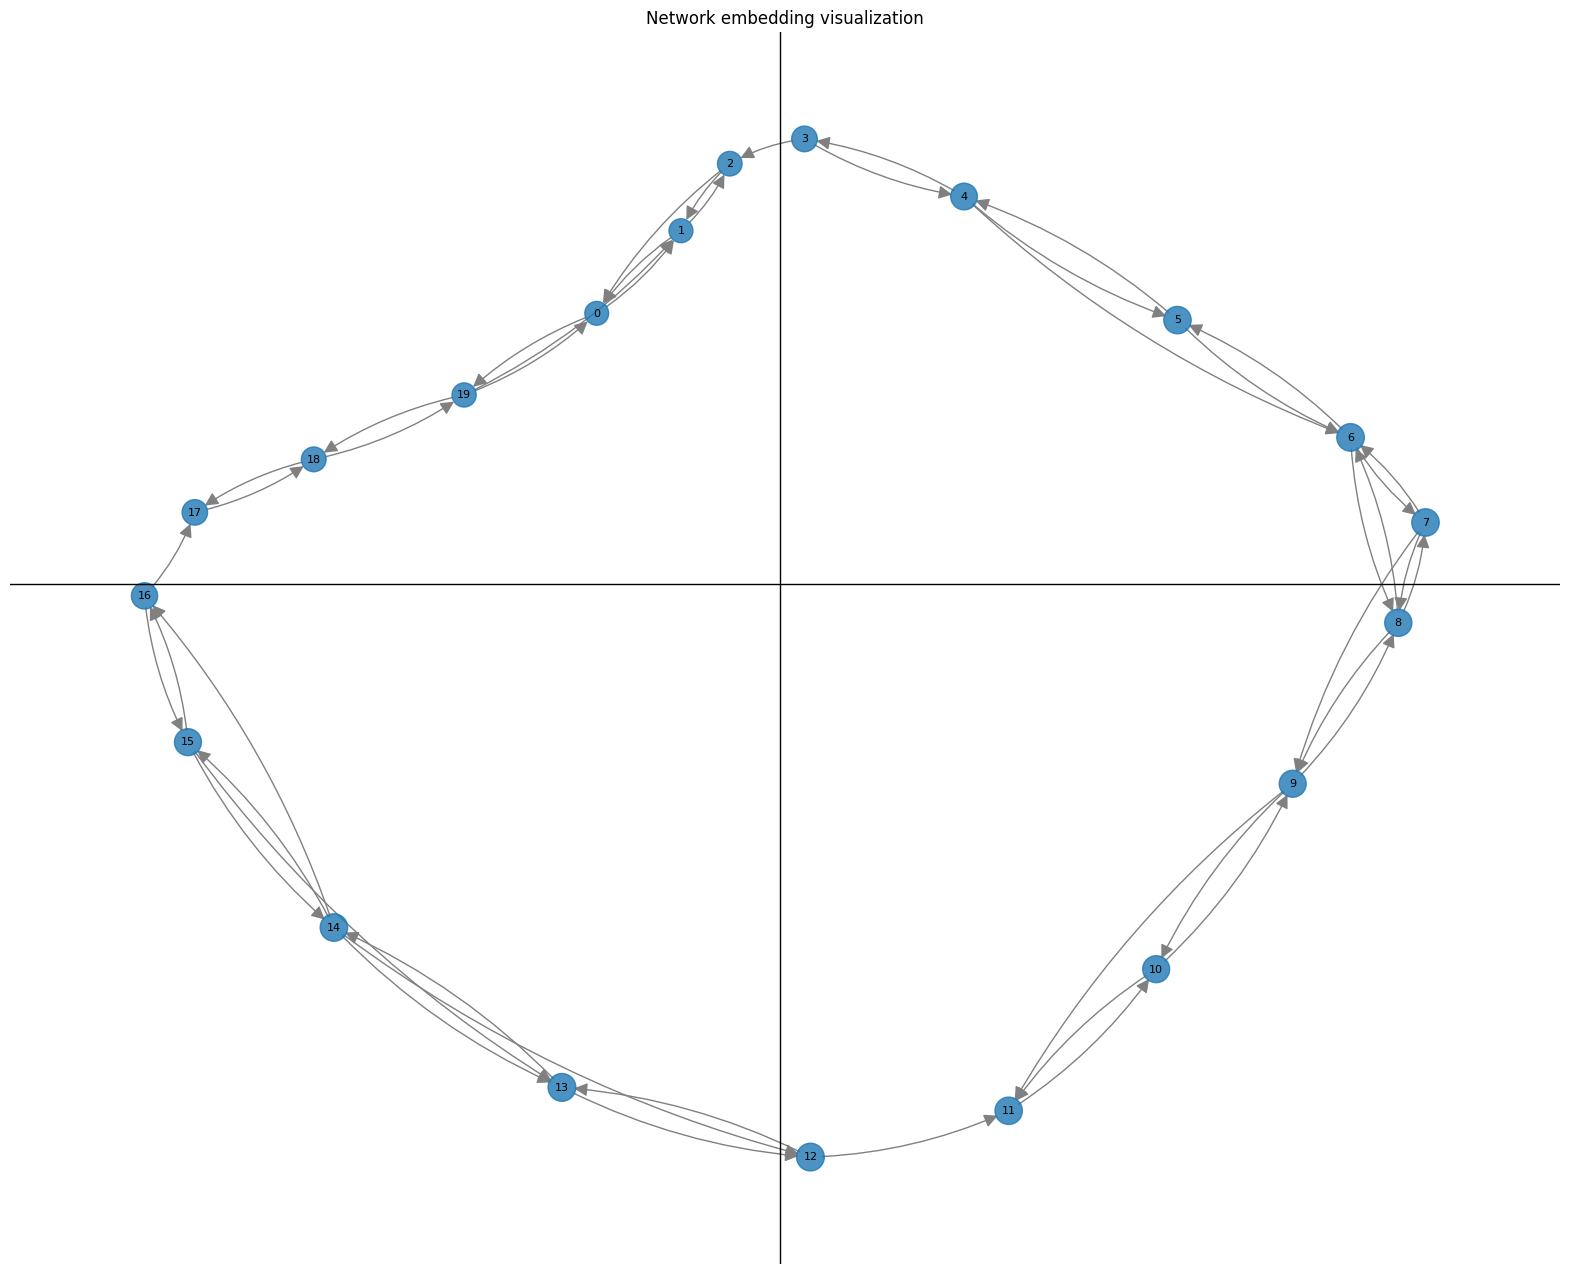

In [80]:
A_gen_ring = simple_model_ring.generate(50)
simple_model_ring.visualize(
    # node_labels=node_list,
    adj_matrix=A_gen_ring,
)

## Test the simple model on custom embeddings (the '+' network)

In [147]:
def get_plus_embeddings(within_group_spacing=1.0, between_group_spacing=1.0):
    embeddings = np.zeros((16, 4))
    for axis in range(4):
        base = 1.0 + axis * between_group_spacing  # starting point for this group
        values = np.arange(base, base + 4 * within_group_spacing, within_group_spacing)  # 4 values spaced by 0.5

        if axis >= 2:
            values *= -1
        for i in range(4):
            idx = axis * 4 + i  # point index
            embeddings[idx, axis % 2] = values[i]
    return embeddings

In [148]:
get_plus_embeddings()

array([[ 1.,  0.,  0.,  0.],
       [ 2.,  0.,  0.,  0.],
       [ 3.,  0.,  0.,  0.],
       [ 4.,  0.,  0.,  0.],
       [ 0.,  2.,  0.,  0.],
       [ 0.,  3.,  0.,  0.],
       [ 0.,  4.,  0.,  0.],
       [ 0.,  5.,  0.,  0.],
       [-3.,  0.,  0.,  0.],
       [-4.,  0.,  0.,  0.],
       [-5.,  0.,  0.,  0.],
       [-6.,  0.,  0.,  0.],
       [ 0., -4.,  0.,  0.],
       [ 0., -5.,  0.,  0.],
       [ 0., -6.,  0.,  0.],
       [ 0., -7.,  0.,  0.]])

In [181]:
simple_model_plus = SequentialHierarchyCommunitySimple(adj_matrix=np.zeros([16, 16]), embedding_dim=2, alpha=5, beta=1)
simple_model_plus.embeddings = get_plus_embeddings()[:, :2]

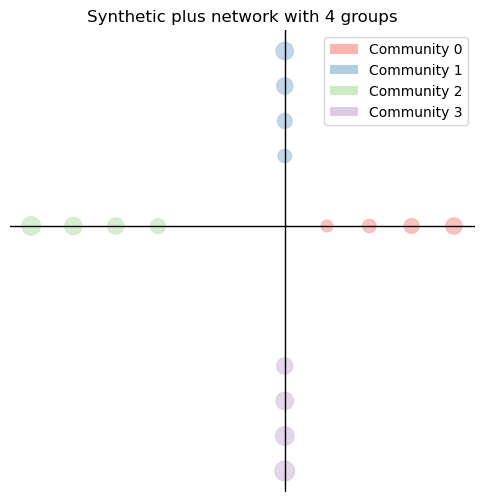

In [182]:
plus_communities = np.repeat(np.arange(4), 4)
simple_model_plus.visualize(
    # node_labels=node_list,
    title="Synthetic plus network with 4 groups",
    figsize=(6, 6),
    draw_labels=False,
    draw_edges=False,
    communities=plus_communities,
    node_size_base=50
)

26.0 edges in generated plus network


Text(0.5, 1.0, 'Adjacency matrix generated from synthetic plus network')

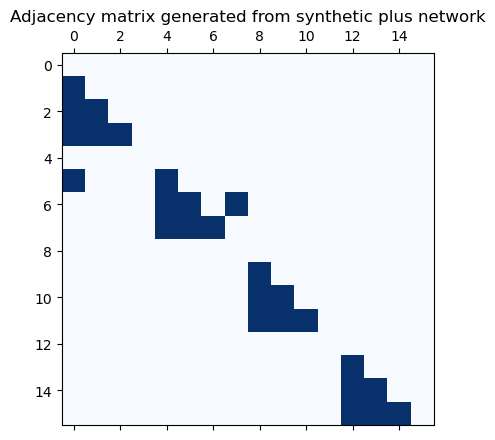

In [184]:
A_gen_plus = simple_model_plus.generate(32)
print(f"{A_gen_plus.sum()} edges in generated plus network")
plt.matshow(A_gen_plus, cmap="Blues")
plt.title("Adjacency matrix generated from synthetic plus network")

#### Infer new embeddings from synthetic network generated on plus embeddings

100%|██████████| 300/300 [00:02<00:00, 105.97it/s]


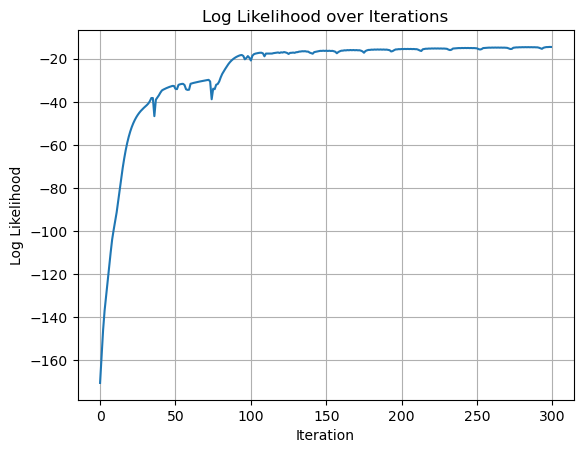

In [185]:
simple_model_plus_inferred = SequentialHierarchyCommunitySimpleJAX(A_gen_plus, embedding_dim=2, alpha=5, beta=1)
_ = simple_model_plus_inferred.fit()

#### Evaluate inferred plus embeddings vs. original embeddings

In [192]:
# cluster embeddings using k-means with ground truth number of clusters
inferred_communities = simple_model_plus_inferred.get_community_structure(n_clusters=4)
# compute NMI
print(f"NMI between inferred and true plus communities: {normalized_mutual_info_score(plus_communities, inferred_communities)}")
# evaluate within-group ranks
plus_ranks = simple_model_plus.get_embedding_norms()
print(f"Within-group Spearman rank correlation coefficients: {simple_model_plus_inferred.evaluate_ranks_within_communities(plus_ranks, plus_communities)}")
# evaluate group-level ranks
true_group_ranks = np.arange(4)
print(f"Group-level Spearman rank correlation coefficient: {simple_model_plus_inferred.evaluate_community_ranks(true_group_ranks, plus_communities)}")

NMI between inferred and true plus communities: 1.0
Within-group Spearman rank correlation coefficients: [1.0, 1.0, 1.0, 1.0]
Group-level Spearman rank correlation coefficient: (0.39999999999999997, array([1.75870037, 1.90724897, 1.83908272, 1.85309851]))


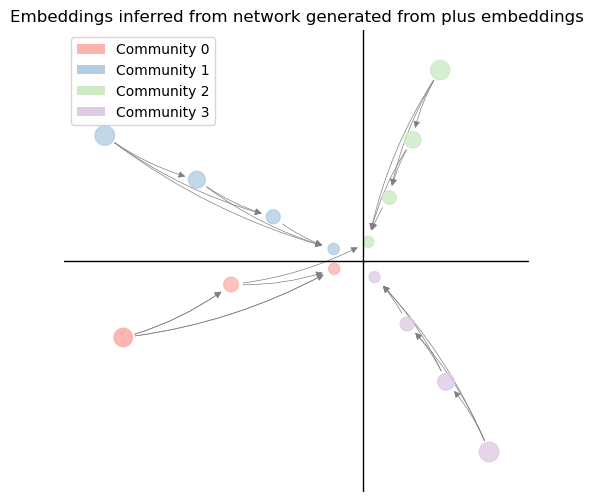

In [190]:
simple_model_plus_inferred.visualize(
    figsize=(6, 6),
    title="Embeddings inferred from network generated from plus embeddings",
    draw_labels=False,
    communities=inferred_communities,
    node_size_base=50
)

# Test the multigraph model on the plus network

In [213]:
multigraph_model_plus = SequentialHierarchyCommunityMulti(adj_matrix=np.ones([16, 16]), embedding_dim=4, alpha=3, beta=1)
multigraph_model_plus.embeddings = get_plus_embeddings()

/var/folders/y_/2bb9t7kj1ql5pvbqf85sggh40000gs/T/ipykernel_94277/3153930267.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/y_/2bb9t7kj1ql5pvbqf85sggh40000gs/T/ipykernel_94277/3153930267.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/y_/2bb9t7kj1ql5pvbqf85sggh40000gs/T/ipykernel_94277/3153930267.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()
/var/folders/y_/2bb9t7kj1ql5pvbqf85sggh40000gs/T/ipykernel_94277/3153930267.py:15: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore 

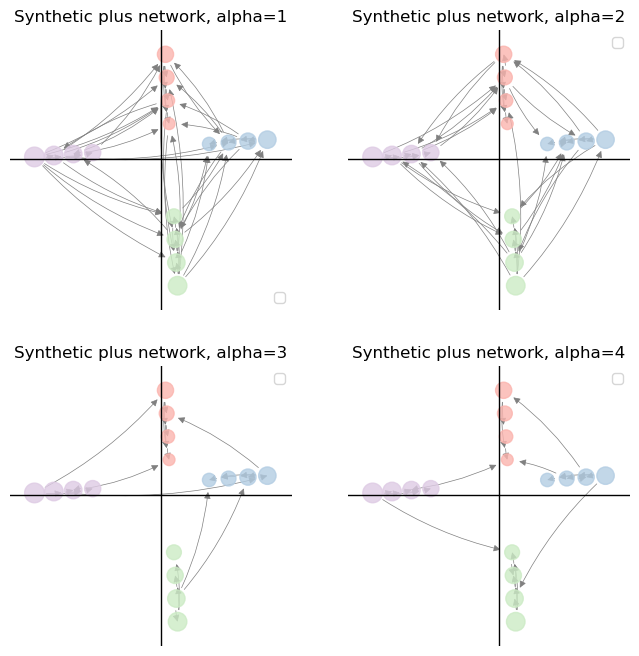

In [ ]:
_, axs = plt.subplots(2, 2, figsize=(8, 8))
for i, alpha in enumerate([1, 2, 3, 4]):
    multigraph_model_plus.alpha = alpha
    A_gen_alpha = multigraph_model_plus.generate(1000)
    ax = axs[i // 2, i % 2]
    multigraph_model_plus.visualize(
        # node_labels=node_list,
        title=f"Synthetic plus network, alpha={alpha}",
        ax=ax,
        adj_matrix=A_gen_alpha,
        draw_labels=False,
        draw_legend=i == 0,
        communities=plus_communities,
        node_size_base=50
    )

# A_gen_plus_multi = multigraph_model_plus.generate(1000)
# multigraph_model_plus.visualize(
#     # node_labels=node_list,
#     title="Synthetic plus network with 4 groups",
#     adj_matrix=A_gen_plus_multi,
#     figsize=(6, 6),
#     draw_labels=False,
#     communities=plus_communities,
#     node_size_base=50
# )

100%|██████████| 300/300 [00:01<00:00, 219.06it/s]


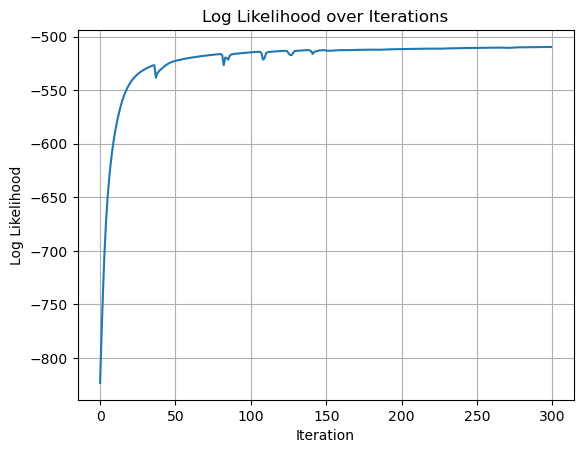

In [225]:
multigraph_model_plus_inferred = SequentialHierarchyCommunityMulti(A_gen_plus_multi, embedding_dim=4, alpha=3, beta=1)
_ = multigraph_model_plus_inferred.fit()

In [227]:
# cluster embeddings using k-means with ground truth number of clusters
inferred_communities_multi = multigraph_model_plus_inferred.get_community_structure(n_clusters=4)
# compute NMI
print(f"NMI between inferred and true plus communities: {normalized_mutual_info_score(plus_communities, inferred_communities)}")
# evaluate within-group ranks
plus_ranks = multigraph_model_plus.get_embedding_norms()
print(f"Within-group Spearman rank correlation coefficients: {multigraph_model_plus_inferred.evaluate_ranks_within_communities(plus_ranks, plus_communities)}")
# evaluate group-level ranks
true_group_ranks = np.arange(4)
print(f"Group-level Spearman rank correlation coefficient: {multigraph_model_plus_inferred.evaluate_community_ranks(true_group_ranks, plus_communities)}")

NMI between inferred and true plus communities: 1.0
Within-group Spearman rank correlation coefficients: [1.0, 1.0, 1.0, 1.0]
Group-level Spearman rank correlation coefficient: (-0.19999999999999998, array([2.11651989, 3.00278909, 3.0764133 , 2.08697608]))


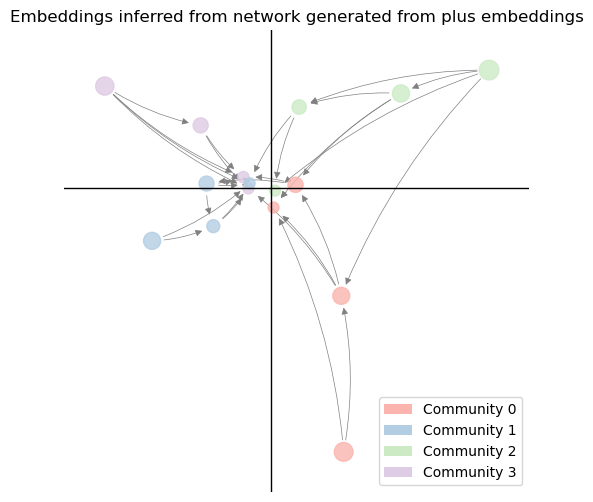

In [230]:
multigraph_model_plus_inferred.visualize(
    figsize=(6, 6),
    title="Embeddings inferred from network generated from plus embeddings",
    draw_labels=False,
    communities=inferred_communities_multi,
    node_size_base=50,
)

# Test multigraph model on NCAA football data

In [4]:
df_ncaa = pd.read_csv('data/cfb_box-scores_2002-2024.csv')
# Create a df with the relevant columns only
df_ncaa_truncated = df_ncaa[['season', 'week', 'date', 'game_type', 'away', 'home', 'conf_away', 'conf_home', 'score_away', 'score_home', 'attendance', 'tv']]

In [5]:
# Check columns
df_ncaa.columns

Index(['season', 'week', 'date', 'time_et', 'game_type', 'away', 'home',
       'rank_away', 'rank_home', 'conf_away', 'conf_home', 'neutral',
       'score_away', 'score_home', 'q1_away', 'q2_away', 'q3_away', 'q4_away',
       'ot_away', 'q1_home', 'q2_home', 'q3_home', 'q4_home', 'ot_home',
       'first_downs_away', 'first_downs_home', 'third_down_comp_away',
       'third_down_att_away', 'third_down_comp_home', 'third_down_att_home',
       'fourth_down_comp_away', 'fourth_down_att_away',
       'fourth_down_comp_home', 'fourth_down_att_home', 'pass_comp_away',
       'pass_att_away', 'pass_yards_away', 'pass_comp_home', 'pass_att_home',
       'pass_yards_home', 'rush_att_away', 'rush_yards_away', 'rush_att_home',
       'rush_yards_home', 'total_yards_away', 'total_yards_home', 'fum_away',
       'fum_home', 'int_away', 'int_home', 'pen_num_away', 'pen_yards_away',
       'pen_num_home', 'pen_yards_home', 'possession_away', 'possession_home',
       'attendance', 'tv'],
      dt

In [6]:
# Replace NaN conference entries with "no-conference"
df_ncaa_truncated['conf_away'] = df_ncaa_truncated['conf_away'].fillna('no-conference')
df_ncaa_truncated['conf_home'] = df_ncaa_truncated['conf_home'].fillna('no-conference')

/var/folders/y_/2bb9t7kj1ql5pvbqf85sggh40000gs/T/ipykernel_94277/366918579.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ncaa_truncated['conf_away'] = df_ncaa_truncated['conf_away'].fillna('no-conference')
/var/folders/y_/2bb9t7kj1ql5pvbqf85sggh40000gs/T/ipykernel_94277/366918579.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ncaa_truncated['conf_home'] = df_ncaa_truncated['conf_home'].fillna('no-conference')


In [7]:
# Create a df for the 2006 season
df_ncaa_truncated_2006 = df_ncaa_truncated[df_ncaa_truncated.season == 2006]

## Create a network of the 2006 season

In [8]:
# Form a dict of all teams in the data and their conferences from the home and away columns
teams_conf_dict = {}
for team, conf in df_ncaa_truncated_2006[['home', 'conf_home']].drop_duplicates().to_dict(orient='split', index=False)['data']:
    teams_conf_dict[team] = conf
for team, conf in df_ncaa_truncated_2006[['away', 'conf_away']].drop_duplicates().to_dict(orient='split', index=False)['data']:
    teams_conf_dict[team] = conf

# Create a list of teams - maps teams to index for creating the adj matrix
teams_list = list(teams_conf_dict.keys())
# Create a list of conferences
conf_list = list(set(teams_conf_dict.values()))

In [9]:
# Create the adjacency matrix of the 2006 season
A_ncaa_2006 = np.zeros([len(teams_list), len(teams_list)])

for idx, data in df_ncaa_truncated_2006.iterrows():
    if data.score_home > data.score_away:
        A_ncaa_2006[teams_list.index(data.home), teams_list.index(data.away)] += 1
    else:
        A_ncaa_2006[teams_list.index(data.away), teams_list.index(data.home)] += 1

## Run the simple model on the 2006 network

100%|██████████| 300/300 [00:03<00:00, 93.39it/s]


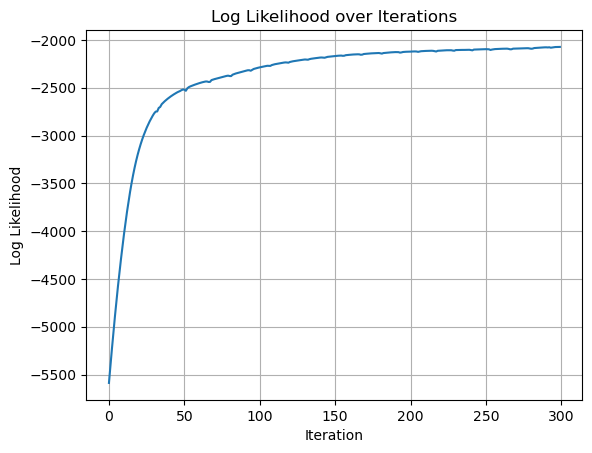

In [24]:
simple_model_ncaa = SequentialHierarchyCommunitySimpleJAX(adj_matrix=A_ncaa_2006, embedding_dim=4, alpha=5, beta=1, random_seed=42)
_ = simple_model_ncaa.fit()

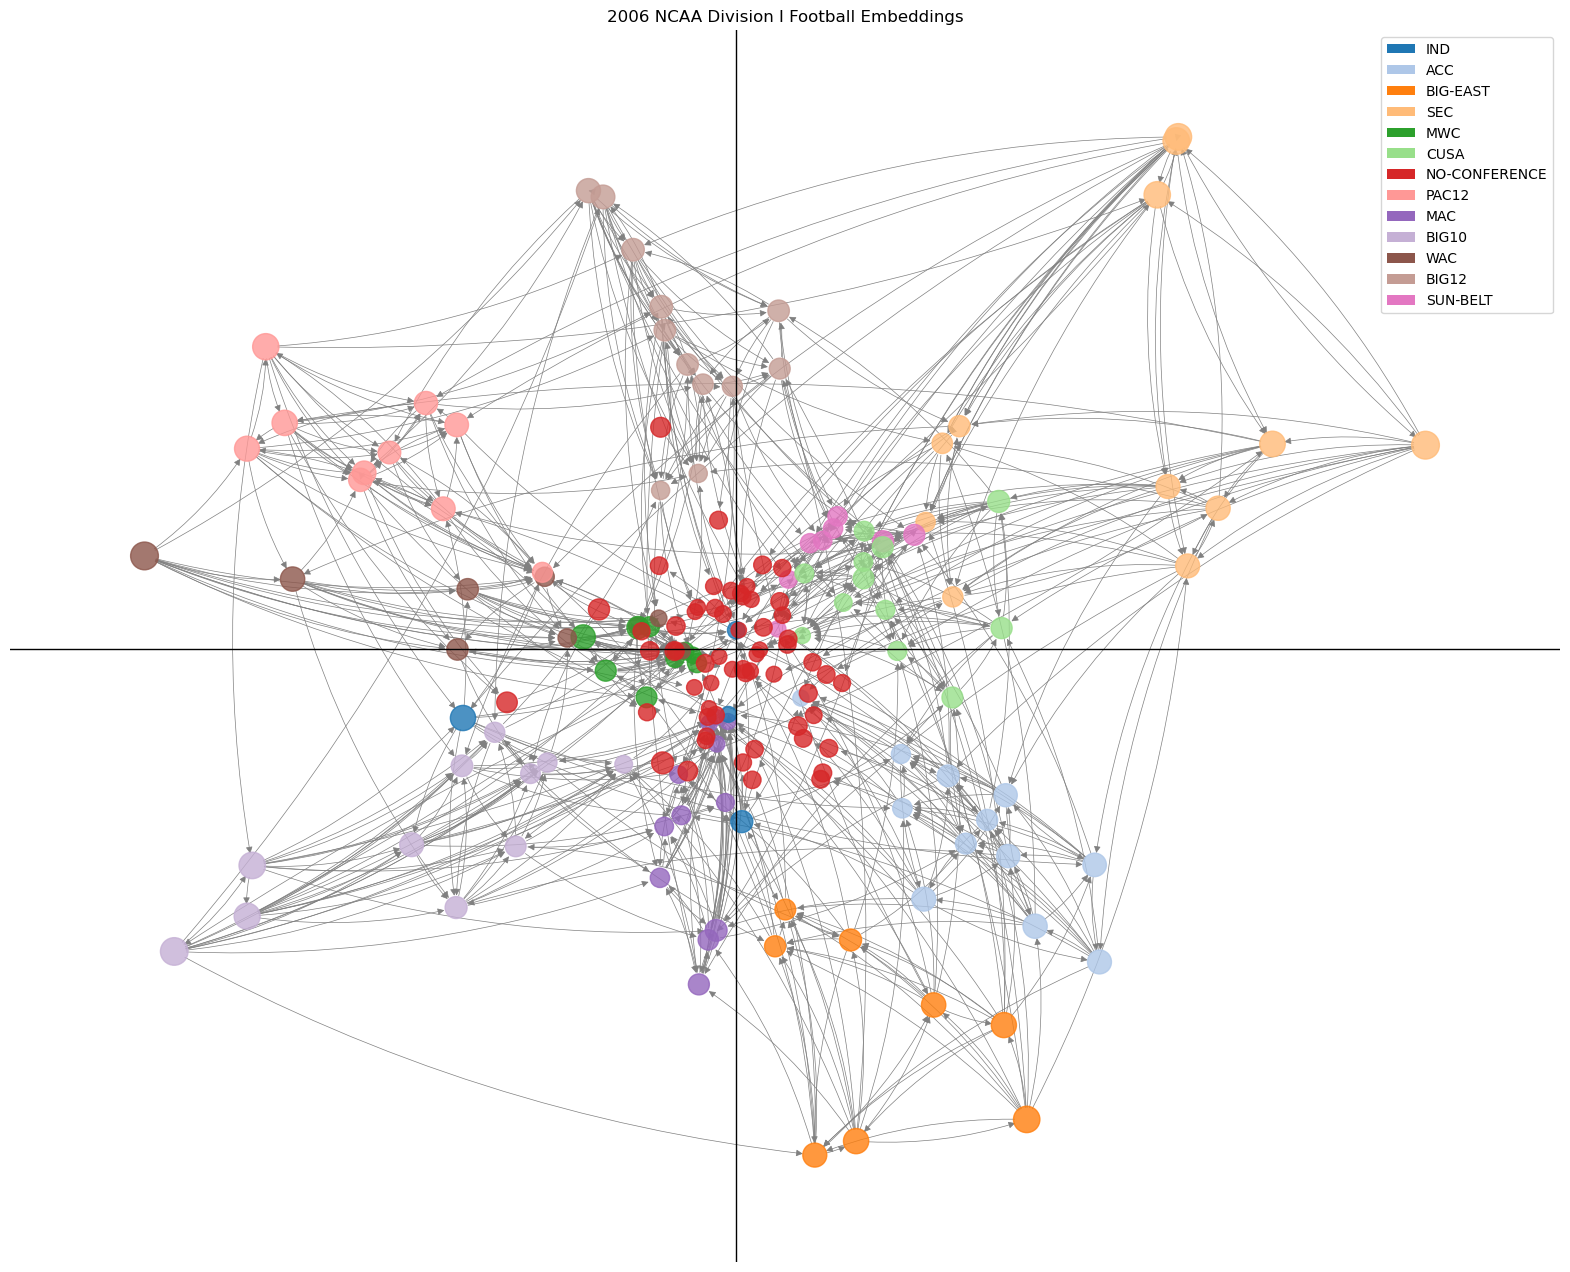

In [25]:
simple_model_ncaa.visualize(draw_labels=False, communities=[conf_list.index(teams_conf_dict[team]) for team in teams_list], community_names=[conf.upper() for conf in conf_list], title="2006 NCAA Division I Football Embeddings")

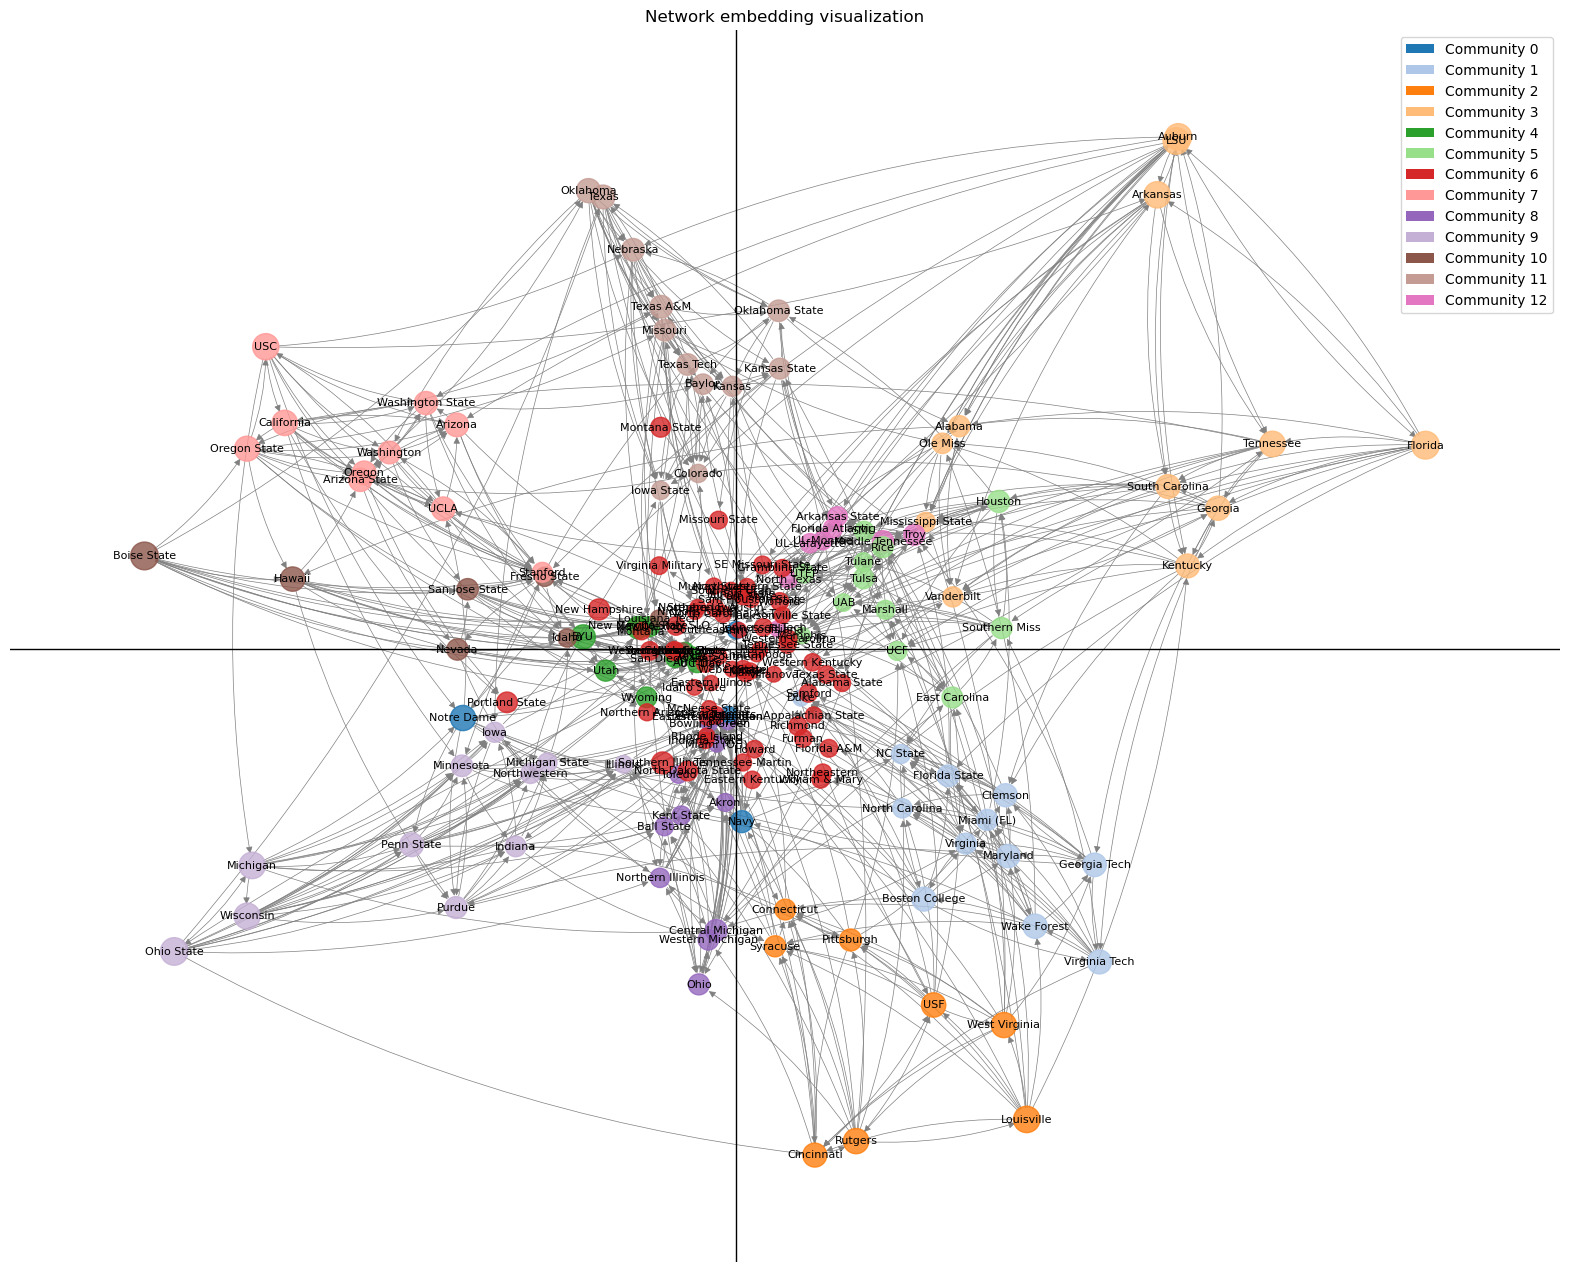

In [26]:
simple_model_ncaa.visualize(node_labels=teams_list, communities=[conf_list.index(teams_conf_dict[team]) for team in teams_list])

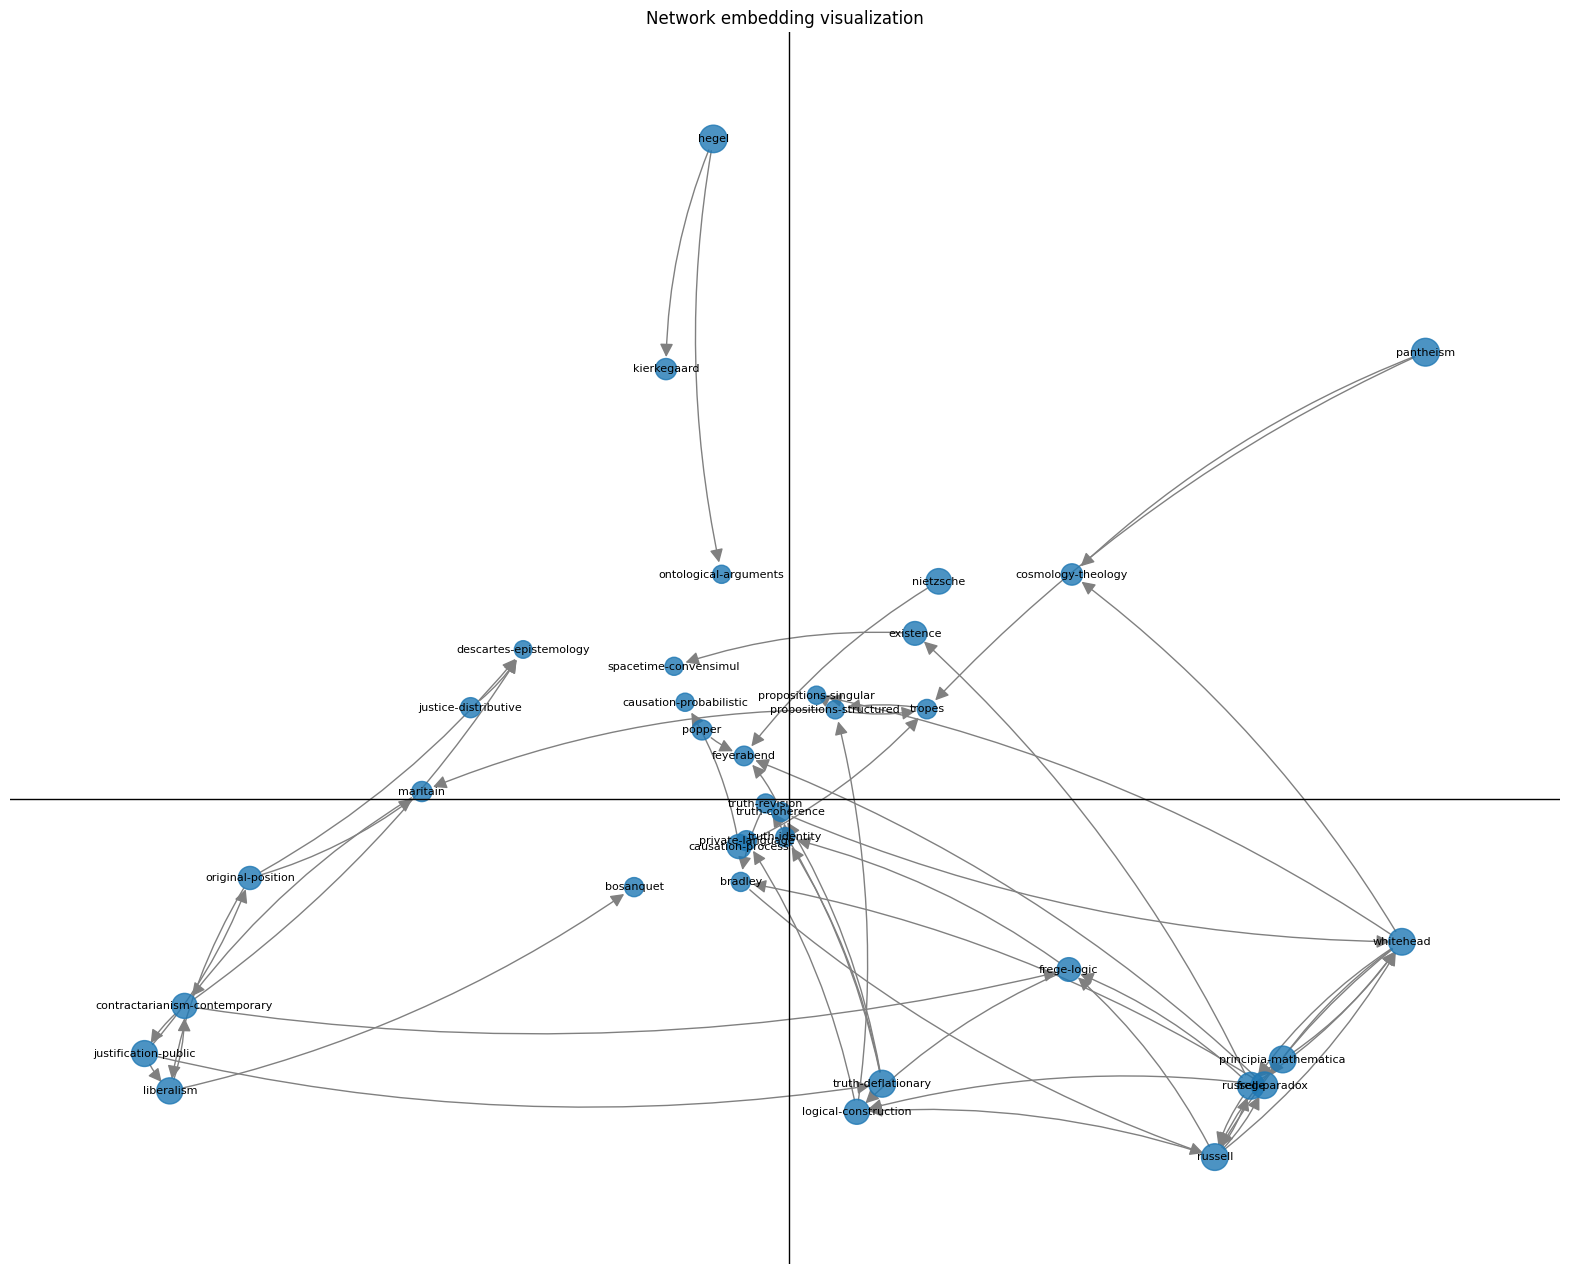

In [ ]:
A_gen_simple_ncaa = simple_model_ncaa.generate()
simple_model_ncaa.visualize(
    node_labels=teams_list,
    adj_matrix=A_gen_simple_ncaa ,
)

## Run the multigraph model on the 2006 network

In [218]:
multigraph_model_ncaa = SequentialHierarchyCommunitySimple(adj_matrix=A_ncaa_2006, embedding_dim=4, alpha=5, beta=1)
_ = multigraph_model_ncaa.fit()

  0%|          | 0/300 [00:00<?, ?it/s]

KeyboardInterrupt: 

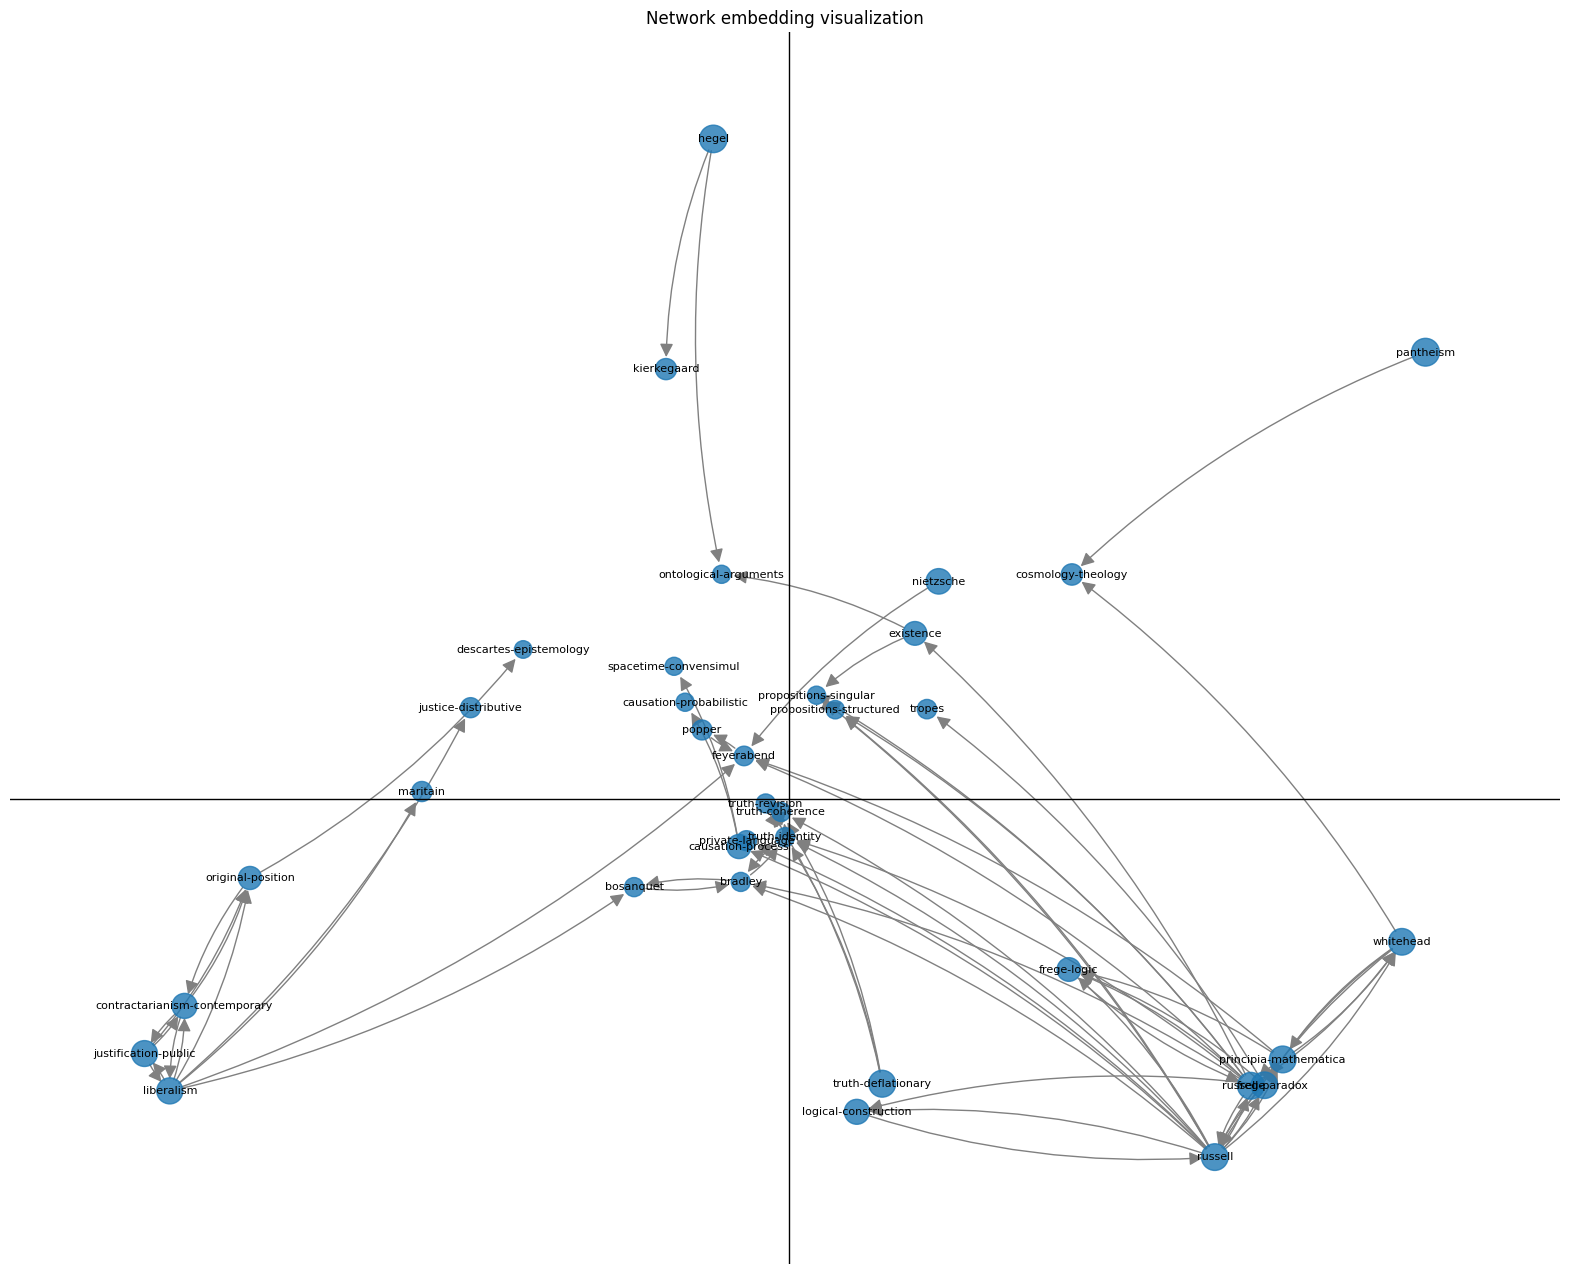

In [ ]:
multigraph_model_ncaa.visualize(node_labels=teams_list)

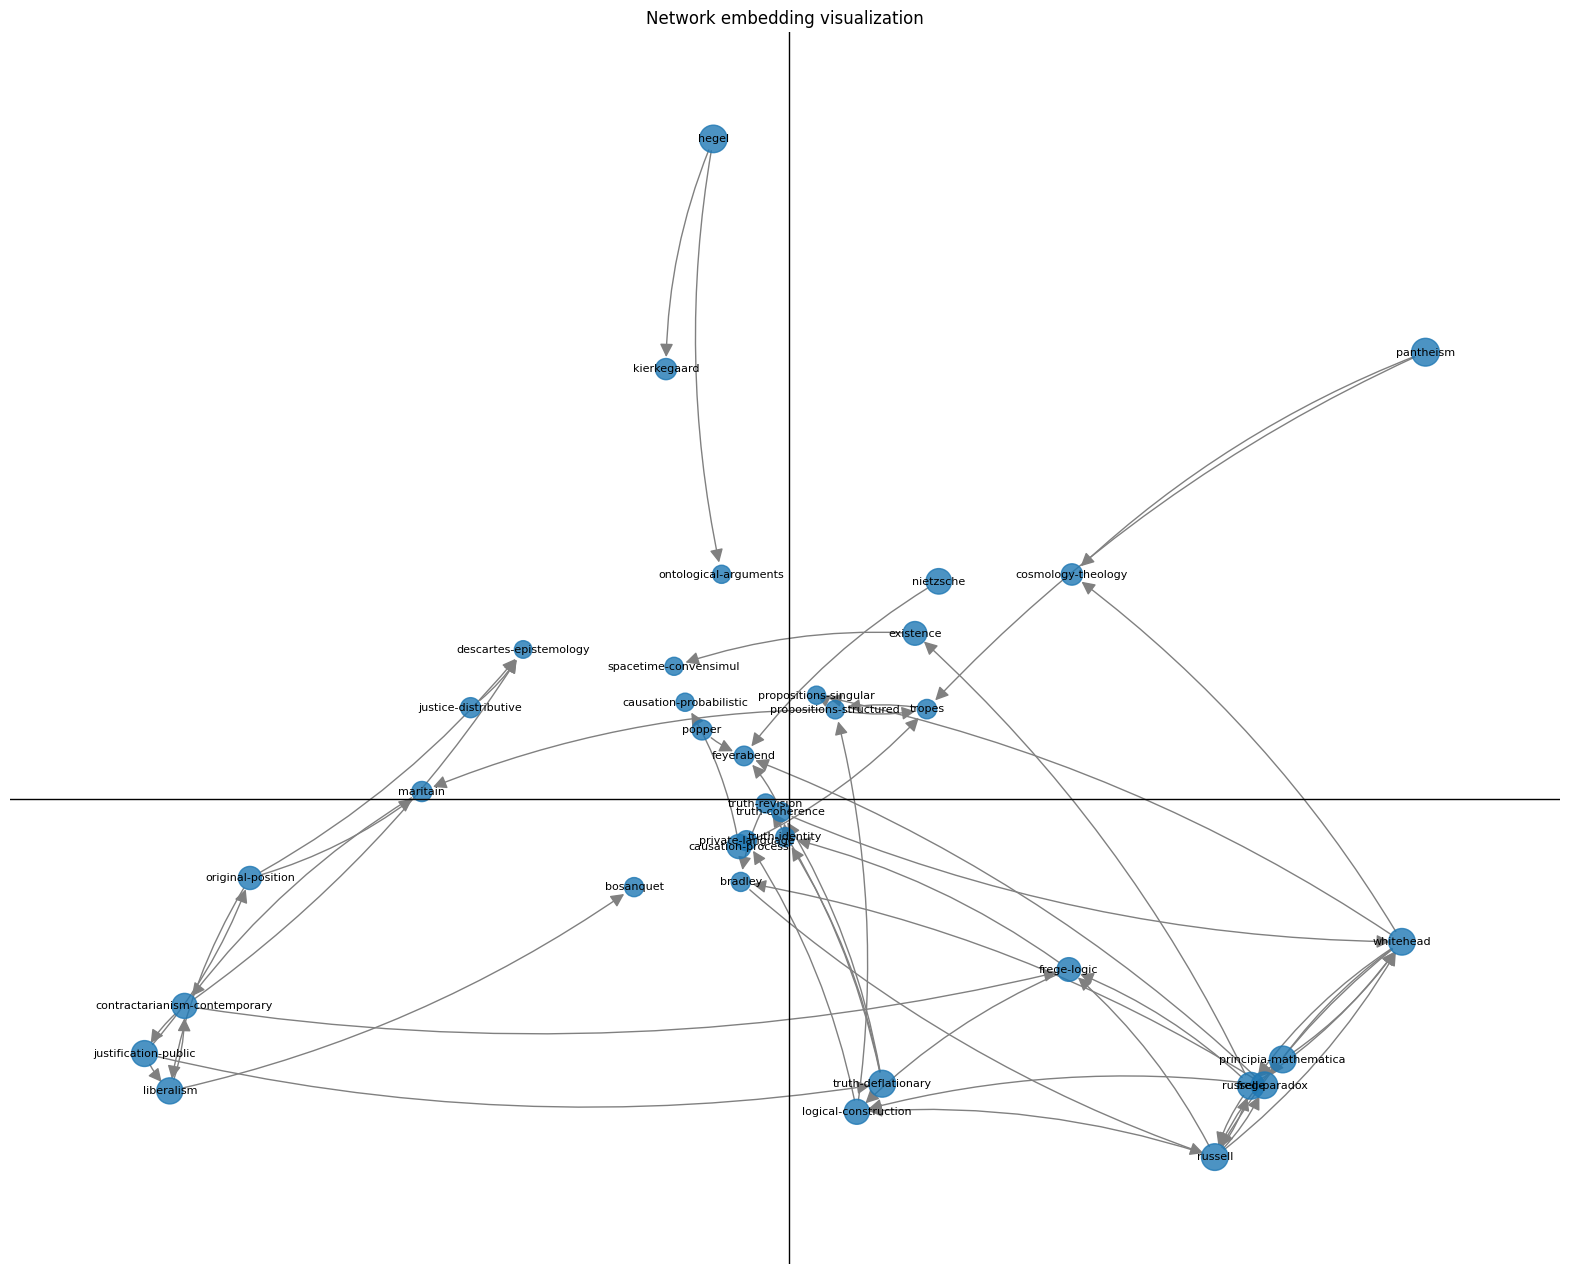

In [ ]:
A_gen_multigraph_ncaa = multigraph_model_ncaa.generate()
multigraph_model_ncaa.visualize(
    node_labels=teams_list,
    adj_matrix=A_gen_multigraph_ncaa ,
)

# Parakeet network

In [ ]:
parakeets = pd.read_csv("data/aggXquarter.txt", sep="\t", header=0)
parakeets.head()

group  study.quarter actor target  number.wins
0    G1              1   bbb    rgn            1
1    G1              1   bgn    bng            2
2    G1              1   bgn    ggg            4
3    G1              1   bgn    grr            1
4    G1              1   bgn    nrb            3

In [ ]:
def get_parakeet_data(group="g1"):

    df = pd.read_csv("data/aggXquarter.txt", sep="\t", header=0)
    df = df[df["group"] == group.upper()]

    G = nx.MultiDiGraph()
    for _, row in df.iterrows():
        G.add_edge(row['actor'], row['target'])

    components = list(nx.weakly_connected_components(G))
    largest_wcc = max(components, key=len)
    G_wcc = G.subgraph(largest_wcc).copy()

    return G_wcc

In [25]:
G_parakeet_g1 = get_parakeet_data("g1")
A_parakeet_g1 = nx.to_numpy_array(G_parakeet_g1, nodelist=G_parakeet_g1.nodes)

### Learn multigraph model with $k=5$

100%|██████████| 500/500 [00:56<00:00,  8.92it/s]


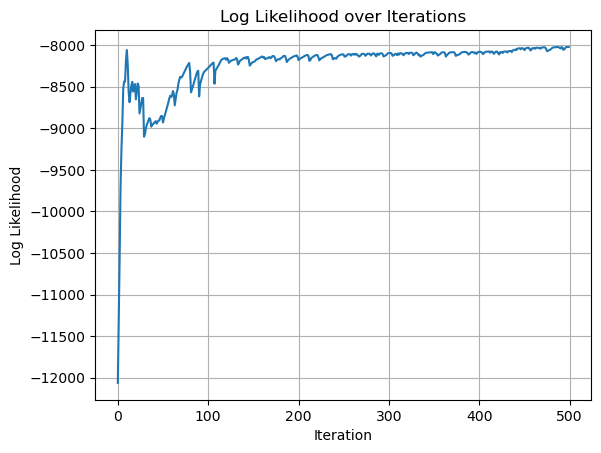

In [38]:
g1_model = SequentialHierarchyCommunityMulti(adj_matrix=A_parakeet_g1, embedding_dim=4, k=5, beta=1)
_ = g1_model.fit(max_iter=500)

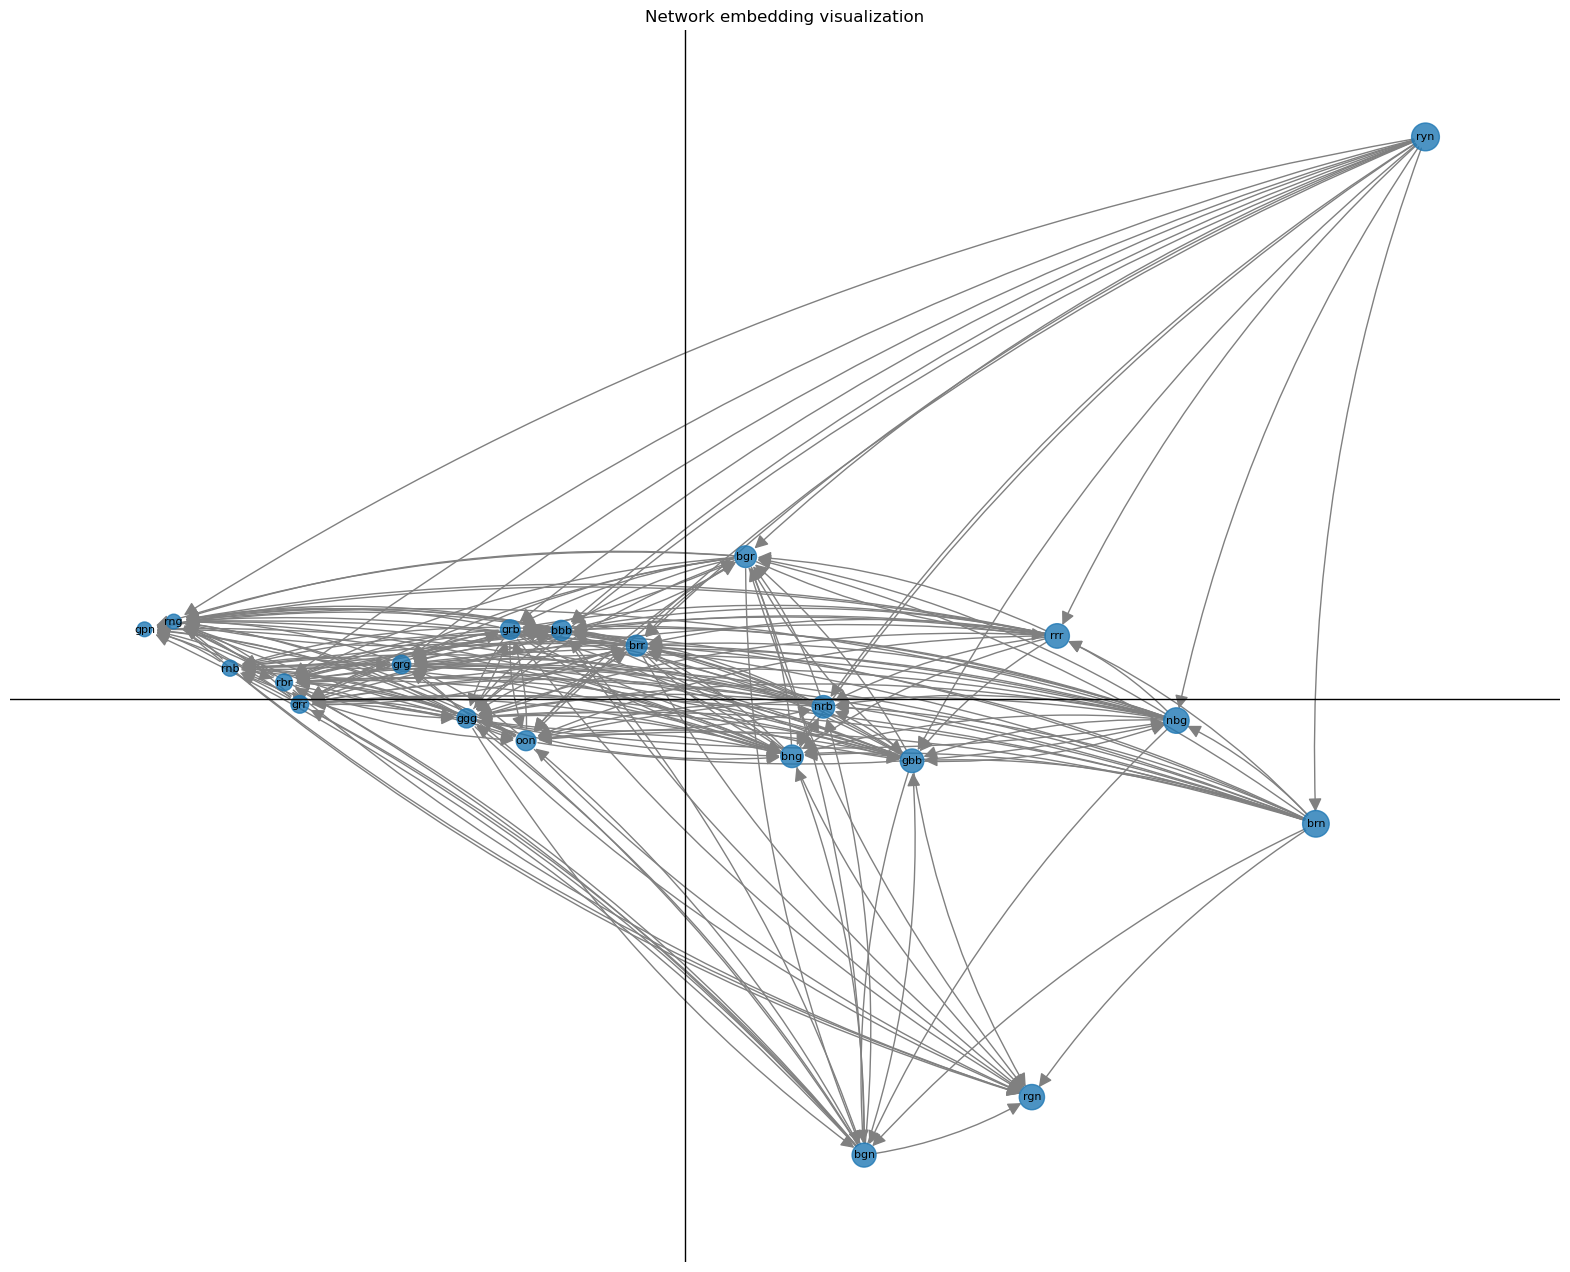

In [40]:
g1_model.visualize(node_labels=list(G_parakeet_g1.nodes))

#### Compare to original network net out degree and SR ranks

In [105]:
t = (A_parakeet_g1 + 1e-8) / (A_parakeet_g1.sum(axis=1) + 1e-8)
eigenvalues, eigenvectors = np.linalg.eig(t)
idx = np.argmax(eigenvalues)

# Get the corresponding eigenvector
largest_eigenvector = eigenvectors[:, idx].real
largest_eigenvalue = eigenvalues[idx].real
print(f"Largest eigenvalue: {largest_eigenvalue}")
print(f"Corresponding eigenvector: {largest_eigenvector}")

Largest eigenvalue: 3.098715613083828
Corresponding eigenvector: [-1.65069284e-01 -1.62972421e-09 -1.82645285e-01 -2.25162091e-01
 -2.85428918e-01 -8.10213348e-02 -1.01978097e-01 -3.16620752e-01
 -3.14030768e-01 -1.75981643e-01 -3.42519224e-01 -4.63599256e-02
 -2.46970422e-01 -2.20153499e-01 -4.17598483e-01 -1.32698725e-01
 -1.29103153e-01 -1.59293934e-01 -1.62972421e-09 -3.01192074e-01
 -8.21020093e-02]


In [100]:
G_weighted = nx.DiGraph()
for u, v, data in G_parakeet_g1.edges(data=True):
    if G_weighted.has_edge(u, v):
        G_weighted[u][v]["weight"] += 1
    else:
        G_weighted.add_edge(u, v, **{"weight": 1})
ec = nx.eigenvector_centrality(G_weighted, max_iter=1000, weight="weight")

/Users/larremoreadmin/miniconda3/envs/networks/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


[]

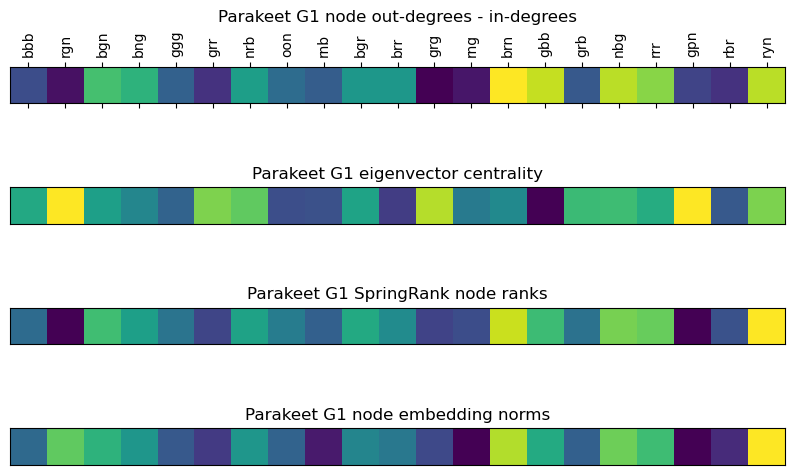

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=(10, 6))

sr_model = SpringRank()
sr_model.fit(A_parakeet_g1)

ax[0].matshow([A_parakeet_g1.sum(axis=1) - A_parakeet_g1.sum(axis=0)])
ax[0].set_title("Parakeet G1 node out-degrees - in-degrees")
ax[0].set_xticks(range(len(G_parakeet_g1.nodes)), G_parakeet_g1.nodes, rotation=90)
ax[0].set_yticks([])

ax[1].matshow([np.array(largest_eigenvector)])
ax[1].set_title("Parakeet G1 eigenvector centrality")
ax[1].set_yticks([])
ax[1].set_xticks([])

ax[2].matshow([sr_model.ranks])
ax[2].set_title("Parakeet G1 SpringRank node ranks")
ax[2].set_yticks([])
ax[2].set_xticks([])

ax[3].matshow([np.linalg.norm(g1_model.embeddings, axis=1)])
ax[3].set_title("Parakeet G1 node embedding norms")
ax[3].set_yticks([])
ax[3].set_xticks([])

### Learn multigraph model with $k=1$

The fit looks a lot better than with $k=5$! The Poisson density already has an $\exp{(-cd_{{ij}})}$ term, so raising $d_{ij}$ to a power is unnecessary.

100%|██████████| 500/500 [00:56<00:00,  8.89it/s]


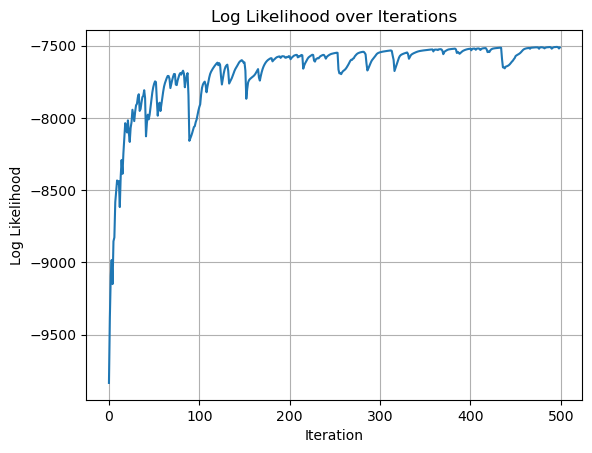

In [108]:
g1_model_k1 = SequentialHierarchyCommunityMulti(adj_matrix=A_parakeet_g1, embedding_dim=4, k=1, beta=1)
_ = g1_model_k1.fit(max_iter=500)

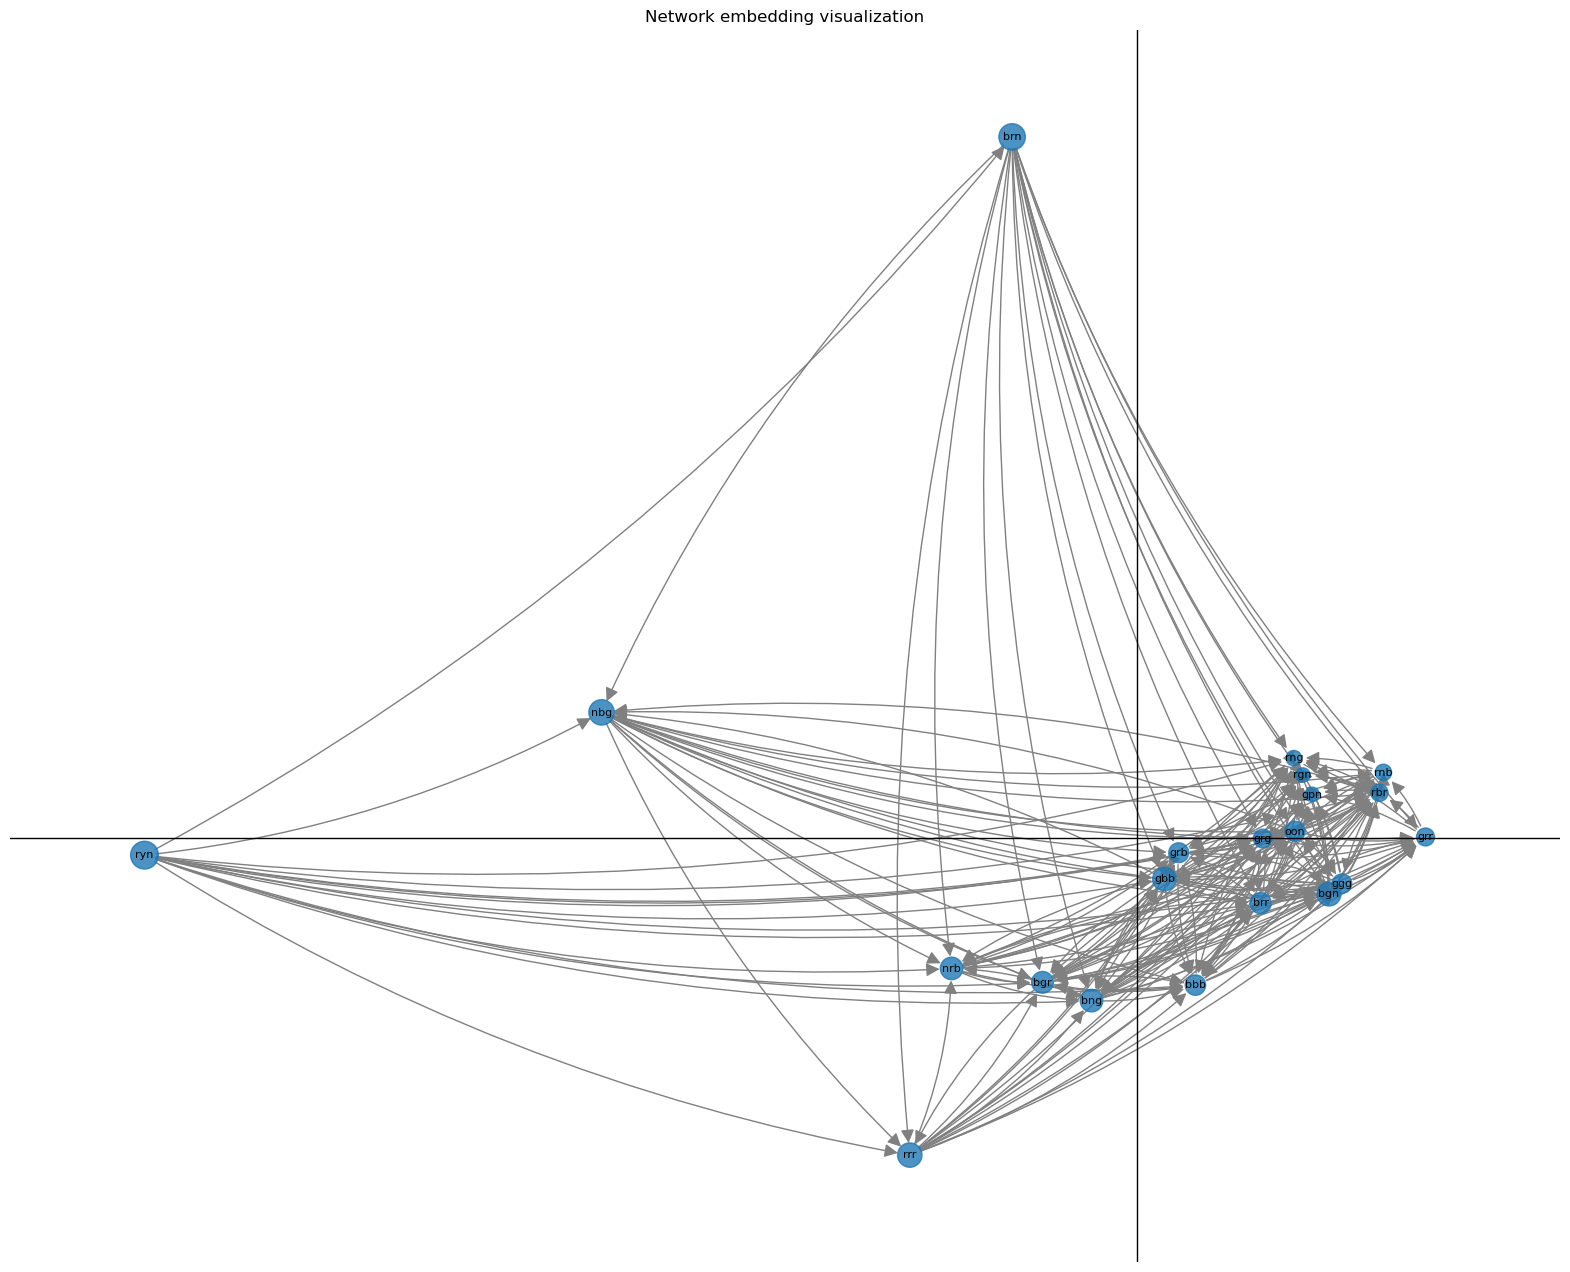

In [109]:
g1_model_k1.visualize(node_labels=list(G_parakeet_g1.nodes))

/Users/larremoreadmin/miniconda3/envs/networks/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


[]

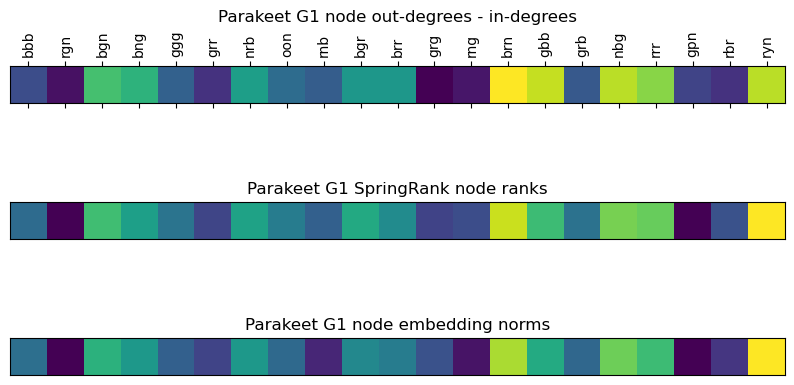

In [110]:
fig, ax = plt.subplots(3, 1, figsize=(10, 5))

sr_model = SpringRank()
sr_model.fit(A_parakeet_g1)

ax[0].matshow([A_parakeet_g1.sum(axis=1) - A_parakeet_g1.sum(axis=0)])
ax[0].set_title("Parakeet G1 node out-degrees - in-degrees")
ax[0].set_xticks(range(len(G_parakeet_g1.nodes)), G_parakeet_g1.nodes, rotation=90)
ax[0].set_yticks([])

ax[1].matshow([sr_model.ranks])
ax[1].set_title("Parakeet G1 SpringRank node ranks")
ax[1].set_yticks([])
ax[1].set_xticks([])

ax[2].matshow([np.linalg.norm(g1_model_k1.embeddings, axis=1)])
ax[2].set_title("Parakeet G1 node embedding norms")
ax[2].set_yticks([])
ax[2].set_xticks([])

# Model -> Data -> Model' Loop

In [73]:
# generate a synthetic parakeet G1 network
m = A_parakeet_g1.sum()
A_gen = g1_model.generate(expected_num_edges=m)
print(A_gen.sum())

456.0


Text(0.5, 1.0, 'Original Parakeet G1 network')

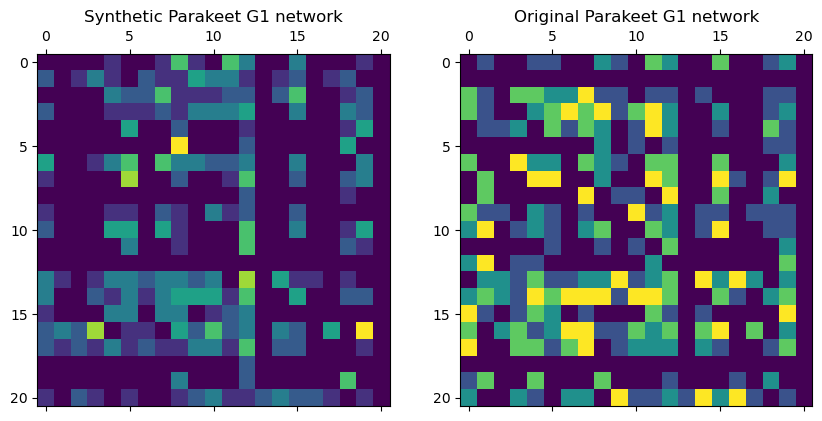

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].matshow(A_gen)
ax[0].set_title("Synthetic Parakeet G1 network")
ax[1].matshow(A_parakeet_g1)
ax[1].set_title("Original Parakeet G1 network")

100%|██████████| 500/500 [00:55<00:00,  8.93it/s]


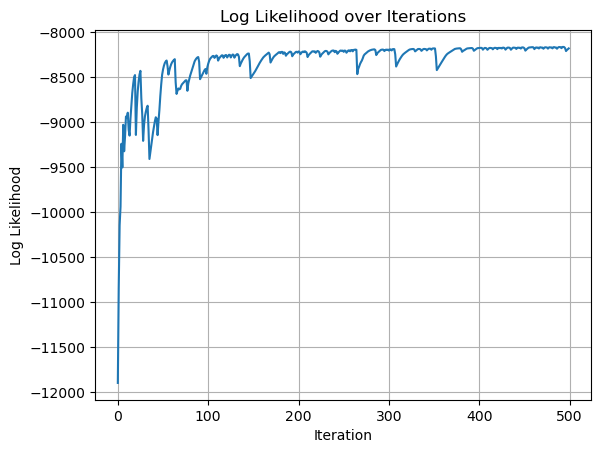

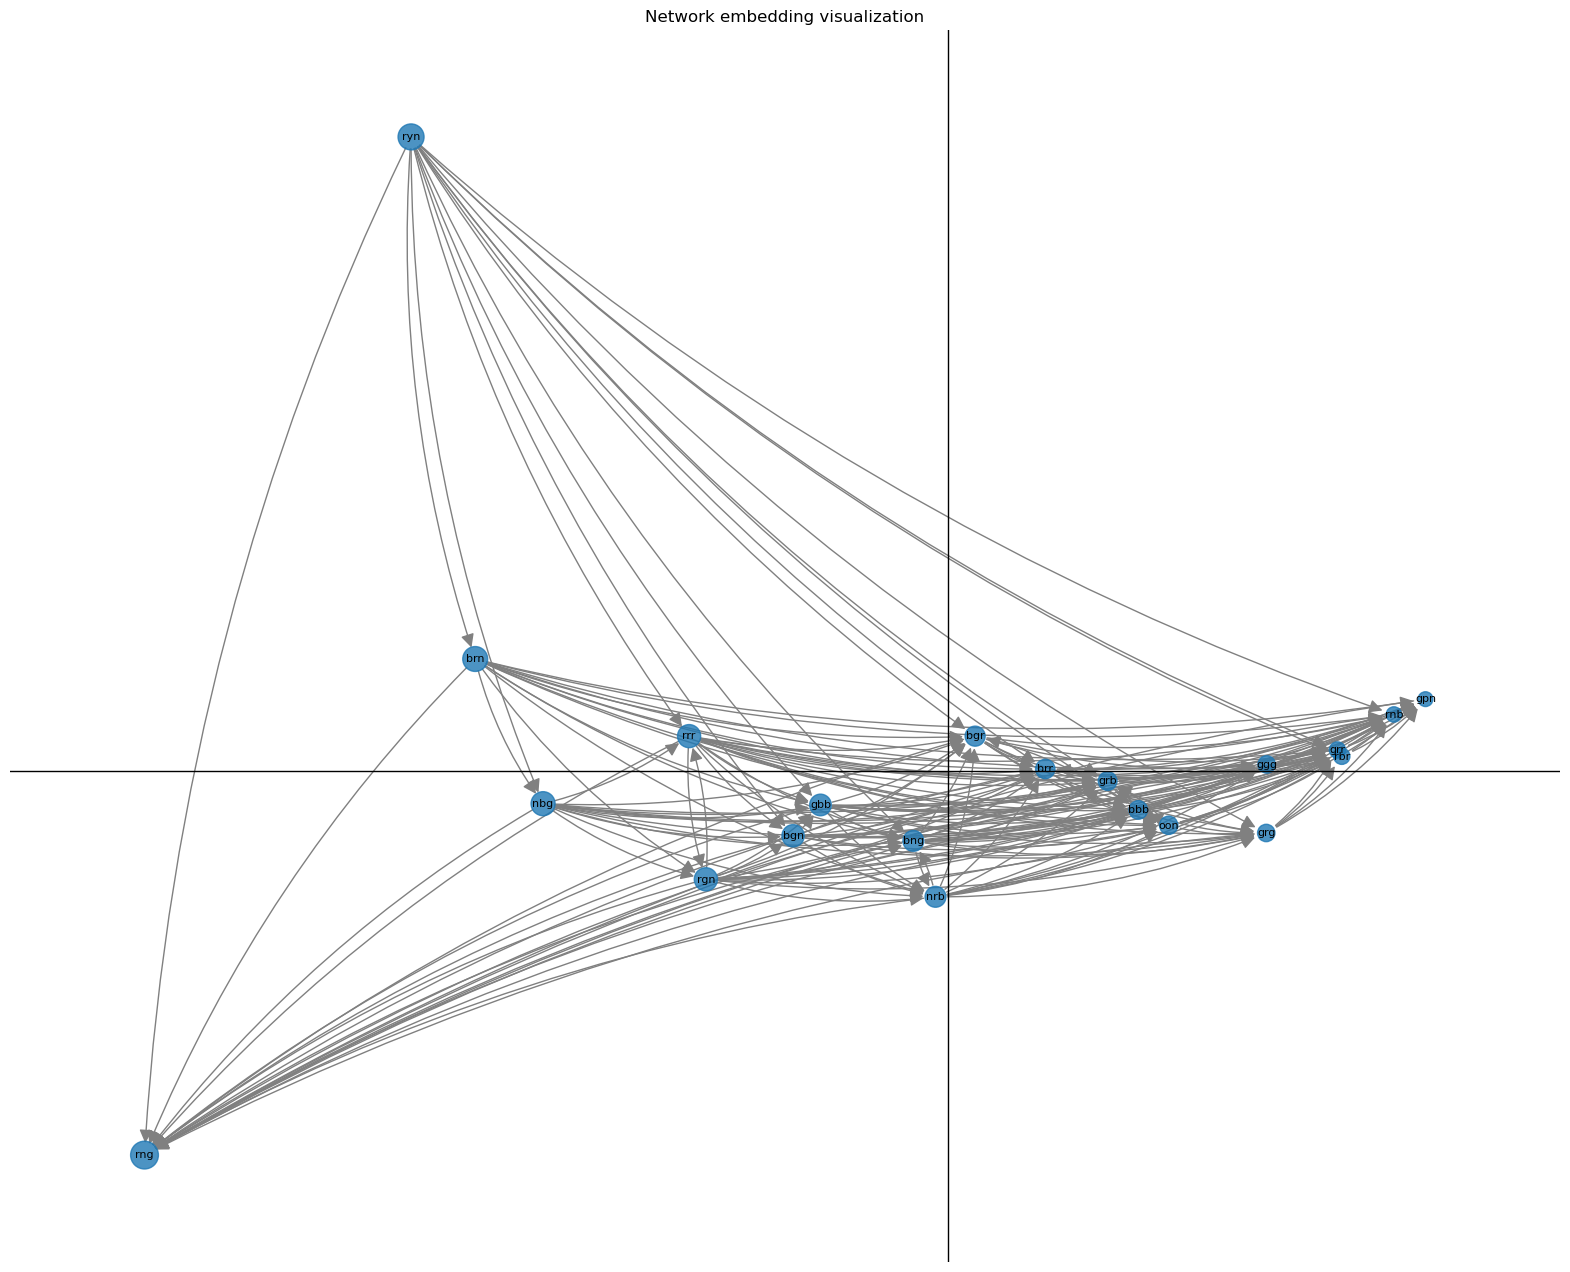

In [78]:
# fit a new model to the synthetic network
g1_model_gen = SequentialHierarchyCommunityMulti(adj_matrix=A_gen, embedding_dim=4, k=5, beta=1)
_ = g1_model_gen.fit(max_iter=500)
g1_model_gen.visualize(node_labels=list(G_parakeet_g1.nodes))

In [84]:
# compare the cosine distances between embeddings in original and synthetic fit models
d_orig = utils.scaled_cosine_sim(g1_model.embeddings)
d_synth = utils.scaled_cosine_sim(g1_model_gen.embeddings)
rho, _ = stats.spearmanr(d_orig.ravel(), d_synth.ravel())
tau, _ = stats.kendalltau(d_orig.ravel(), d_synth.ravel())
jsd = spatial.distance.jensenshannon(d_orig.ravel(), d_synth.ravel())
wd = stats.wasserstein_distance_nd(d_orig, d_synth)
print(f"Spearman correlation: {rho:.4f}")
print(f"Kendall tau correlation: {tau:.4f}")
print(f"Jensen-Shannon divergence: {jsd:.4f}")
print(f"Wasserstein distance: {wd:.4f}")

Spearman correlation: 0.5873
Kendall tau correlation: 0.4272
Jensen-Shannon divergence: 0.0205
Wasserstein distance: 0.2027
